<a href="https://colab.research.google.com/github/Pandey-A/Nomadiq-Task/blob/main/Nomadiq_Flight_Price_Prediction_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomadiq Smart Booking - Flight Price Analysis & Forecasting

## Objective
We have to analyze flight fare data to identify how ticket prices change as departure date approaches across different airlines on the top 5 most in-demand routes.


**IMP : All routes are having Economy Class , One Ways Trip and Single Passanger**

### Routes Analyzed:
1. DEL → DXB (Dubai)
2. BOM → LHR (London Heathrow)
3. DEL → SIN (Singapore)
4. BOM → DOH (Doha)
5. DEL → JFK (New York)

### Analysis Structure:
1. Data Loading & Cleaning
2. Exploratory Data Analysis
3. Price vs Days-to-Departure Analysis
4. Airline Volatility Comparison
5. Price Spike & Drop Detection
6. Optimal Booking Window Identification
7. Time Series Forecasting (ARIMA/SARIMA)
8. Summary Insights & Recommendations

## 1. Import Libraries & Load Data

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [42]:
df = pd.read_csv('final_flight_data_all.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Names: {df.columns.tolist()}")
df.head(10)

Dataset Shape: (1821, 7)

Column Names: ['route', 'flight_date', 'days_to_departure', 'airline', 'price', 'duration', 'stops_count']


,route,flight_date,days_to_departure,airline,price,duration,stops_count
0,BOM-DOH,2025-12-01,1,SriLankan,12548,20 hr 45 min,1 stop
1,BOM-DOH,2025-12-01,1,Air Arabia,16323,15 hr 10 min,1 stop
2,BOM-DOH,2025-12-01,1,Gulf Air,16408,17 hr 35 min,1 stop
3,BOM-DOH,2025-12-01,1,Air Arabia,16764,4 hr 40 min SHJ,1 stop
4,BOM-DOH,2025-12-01,1,IndiGoQatar AirwaysOperated by 6E/Operated Und...,16884,NaN,Nonstop
5,BOM-DOH,2025-12-01,1,Air Arabia,17659,5 hr 15 min,1 stop
6,BOM-DOH,2025-12-01,1,flydubai,18106,6 hr 20 min,1 stop
7,BOM-DOH,2025-12-01,1,Air India,22661,3 hr 55 min,Nonstop
8,BOM-DOH,2025-12-01,1,Air India,22976,NaN,Nonstop
9,BOM-DOH,2025-12-01,1,IndiGoQatar Airways,30408,4 hr 5 min,Nonstop


In [43]:
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nStatistical Summary:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   route              1821 non-null   object
 1   flight_date        1821 non-null   object
 2   days_to_departure  1821 non-null   int64 
 3   airline            1821 non-null   object
 4   price              1821 non-null   int64 
 5   duration           1728 non-null   object
 6   stops_count        1821 non-null   object
dtypes: int64(2), object(5)
memory usage: 99.7+ KB
None


Statistical Summary:


,days_to_departure,price
count,1821.000000,1821.000000
mean,15.641406,33589.505766
std,8.663072,23979.788224
min,1.000000,9883.000000
25%,8.000000,20940.000000
50%,16.000000,28792.000000
75%,23.000000,39430.000000
max,30.000000,646009.000000


## 2. Data Cleaning & Preprocessing

In [44]:
print("Missing Values:")
print(df.isnull().sum())
print(f"\nTotal Missing: {df.isnull().sum().sum()}")

Missing Values:
route                 0
flight_date           0
days_to_departure     0
airline               0
price                 0
duration             93
stops_count           0
dtype: int64

Total Missing: 93


In [45]:
def clean_airline_name(name):
    """Standardize airline names"""
    if pd.isna(name):
        return 'Unknown'

    name = str(name).strip()

    if 'IndiGo' in name or '6E' in name:
        return 'IndiGo'
    elif 'Air India' in name:
        return 'Air India'
    elif 'Qatar Airways' in name:
        return 'Qatar Airways'
    elif 'Emirates' in name:
        return 'Emirates'
    elif 'Etihad' in name:
        return 'Etihad'
    elif 'Singapore Airlines' in name:
        return 'Singapore Airlines'
    elif 'Air Arabia' in name:
        return 'Air Arabia'
    elif 'Akasa' in name:
        return 'Akasa Air'
    elif 'Gulf Air' in name:
        return 'Gulf Air'
    elif 'SriLankan' in name:
        return 'SriLankan'
    elif 'Oman Air' in name:
        return 'Oman Air'
    elif 'flydubai' in name:
        return 'flydubai'
    elif 'Vistara' in name:
        return 'Vistara'
    elif 'British Airways' in name:
        return 'British Airways'
    elif 'Virgin Atlantic' in name:
        return 'Virgin Atlantic'
    elif 'Lufthansa' in name:
        return 'Lufthansa'
    elif 'United' in name:
        return 'United'
    elif 'American' in name and 'Airlines' in name:
        return 'American Airlines'
    elif 'Delta' in name:
        return 'Delta'
    elif 'AirAsia' in name:
        return 'AirAsia'
    elif 'Batik Air' in name:
        return 'Batik Air'
    elif 'Thai Lion' in name:
        return 'Thai Lion Air'
    elif 'Vietjet' in name:
        return 'Vietjet'
    elif 'Malaysia Airlines' in name:
        return 'Malaysia Airlines'
    elif 'Vietnam Airlines' in name:
        return 'Vietnam Airlines'
    else:
        return name.split(',')[0].split('Operated')[0].strip()

df['airline_clean'] = df['airline'].apply(clean_airline_name)

print("Unique Airlines (Cleaned):")
print(df['airline_clean'].value_counts())

Unique Airlines (Cleaned):
airline_clean
IndiGo                 428
Air India              369
Emirates               120
Etihad                 112
British Airways         79
Virgin Atlantic         66
SpiceJet                62
Delta                   60
Singapore Airlines      58
Qatar Airways           49
Gulf Air                47
Air Arabia              39
American                30
flydubai                29
Batik Air               29
SWISS                   26
AirAsia                 24
Air Canada              21
Oman Air                17
Malaysia Airlines       17
Jazeera                 16
Akasa Air               16
SriLankan               13
Azerbaijan Airlines     12
Vietnam Airlines        12
Finnair                 11
Vietjet                 10
Saudia                   8
Flynas                   7
Air Astana               6
Thai Lion Air            5
Air FranceKLM            5
EgyptAir                 5
Cathay Pacific           2
LOT                      2
United        

In [46]:
def clean_stops(stops):
    """Convert stops to numeric"""
    if pd.isna(stops):
        return -1
    stops = str(stops).lower().strip()
    if 'nonstop' in stops or stops == '0':
        return 0
    elif '1 stop' in stops or '1stop' in stops:
        return 1
    elif '2 stop' in stops or '2stop' in stops:
        return 2
    else:
        try:
            return int(stops.split()[0])
        except:
            return 1

df['stops_numeric'] = df['stops_count'].apply(clean_stops)

print("Stops Distribution:")
print(df['stops_numeric'].value_counts())

Stops Distribution:
stops_numeric
0    1017
1     787
2      17
Name: count, dtype: int64


In [47]:
df['flight_date'] = pd.to_datetime(df['flight_date'])

df['day_of_week'] = df['flight_date'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

print("Routes in Dataset:")
print(df['route'].value_counts())

Routes in Dataset:
route
DEL-DXB    490
DEL-SIN    423
BOM-LHR    320
DEL-JFK    303
BOM-DOH    285
Name: count, dtype: int64


In [48]:
df_clean = df[['route', 'flight_date', 'days_to_departure', 'airline_clean', 'price',
               'duration', 'stops_numeric', 'day_of_week', 'is_weekend']].copy()
df_clean.columns = ['route', 'flight_date', 'days_to_departure', 'airline', 'price',
                    'duration', 'stops_count', 'day_of_week', 'is_weekend']

print(f"Cleaned Dataset Shape: {df_clean.shape}")
df_clean.head()

Cleaned Dataset Shape: (1821, 9)


,route,flight_date,days_to_departure,airline,price,duration,stops_count,day_of_week,is_weekend
0,BOM-DOH,2025-12-01,1,SriLankan,12548,20 hr 45 min,1,Monday,0
1,BOM-DOH,2025-12-01,1,Air Arabia,16323,15 hr 10 min,1,Monday,0
2,BOM-DOH,2025-12-01,1,Gulf Air,16408,17 hr 35 min,1,Monday,0
3,BOM-DOH,2025-12-01,1,Air Arabia,16764,4 hr 40 min SHJ,1,Monday,0
4,BOM-DOH,2025-12-01,1,IndiGo,16884,NaN,0,Monday,0


In [49]:
df_clean.to_csv('flight_data_cleaned.csv', index=False)
print("Cleaned data saved to 'flight_data_cleaned.csv'")

Cleaned data saved to 'flight_data_cleaned.csv'


## 3. Exploratory Data Analysis

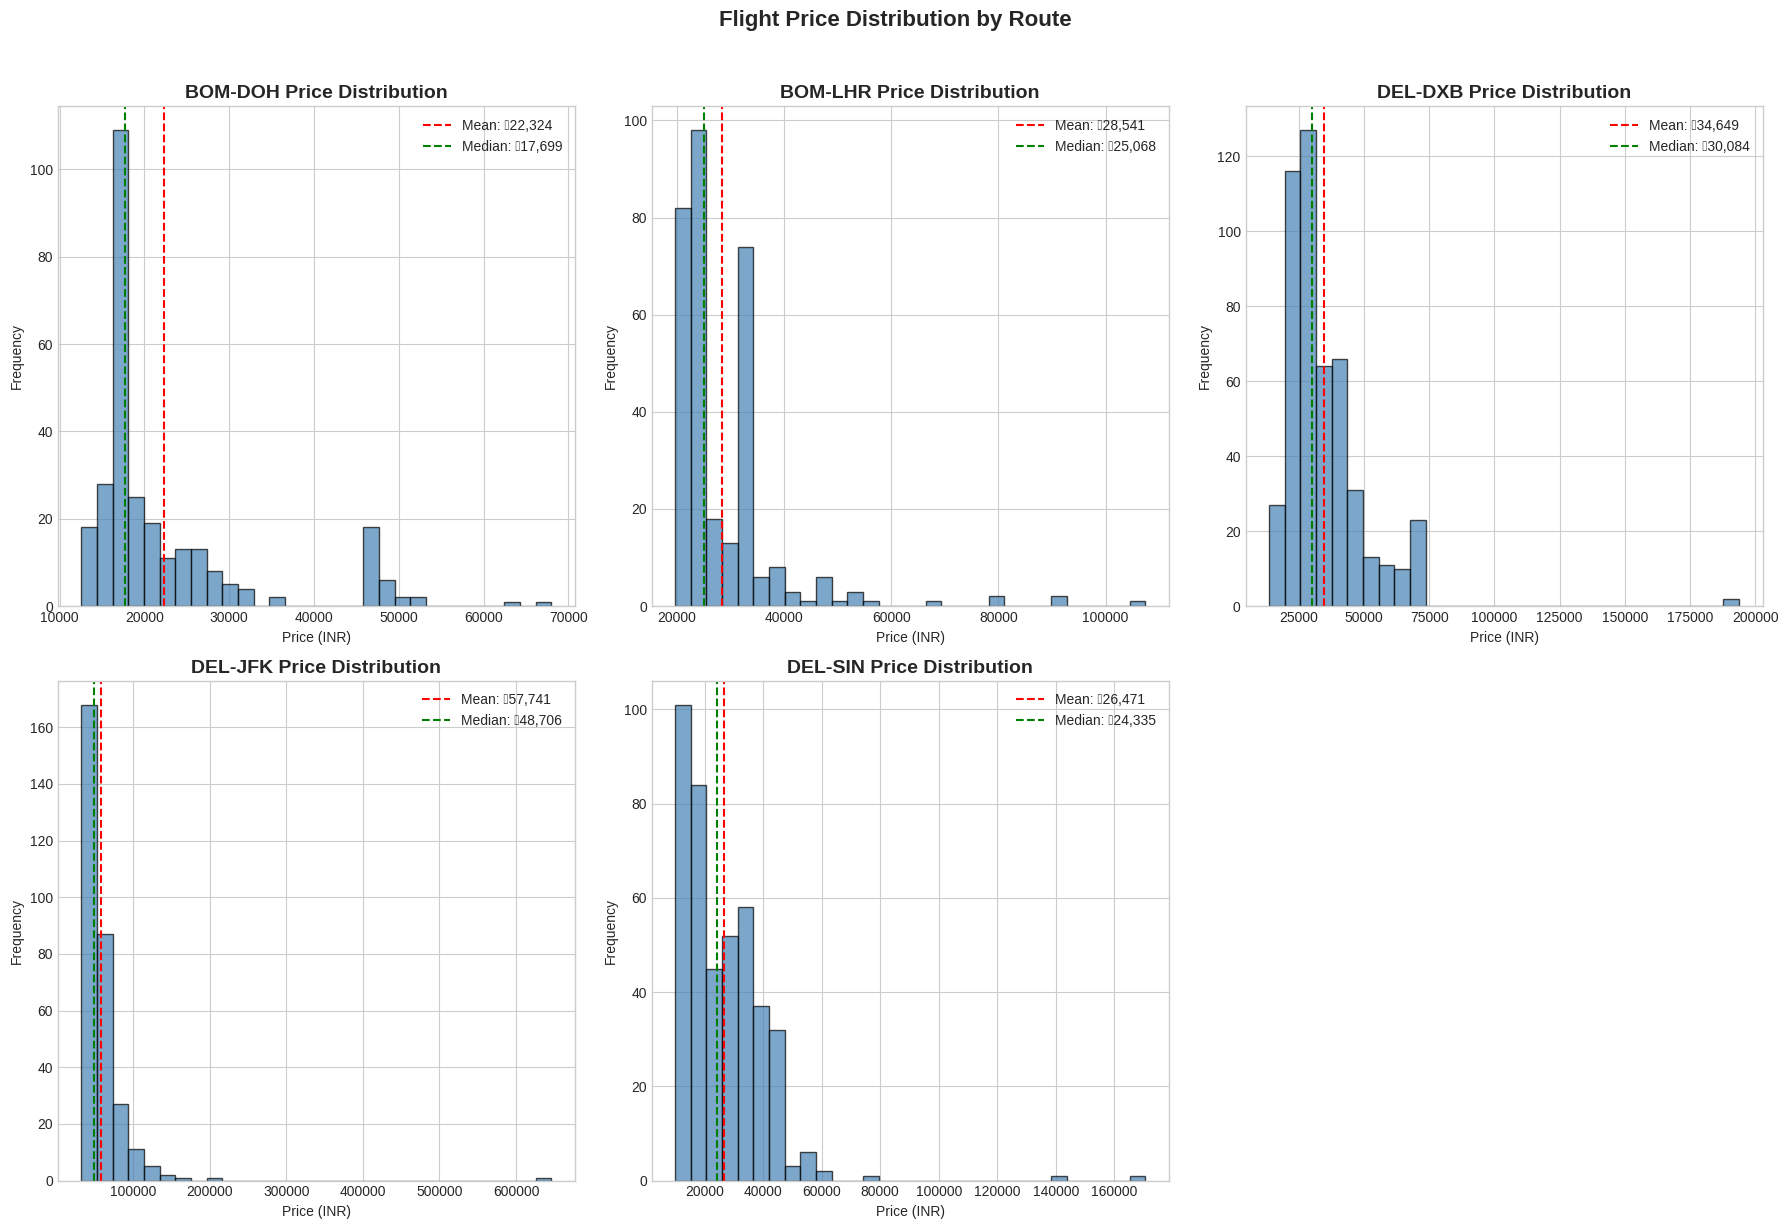

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
routes = df_clean['route'].unique()

for idx, route in enumerate(routes):
    ax = axes[idx // 3, idx % 3]
    route_data = df_clean[df_clean['route'] == route]['price']
    ax.hist(route_data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.set_title(f'{route} Price Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('Price (INR)')
    ax.set_ylabel('Frequency')
    ax.axvline(route_data.mean(), color='red', linestyle='--', label=f'Mean: ₹{route_data.mean():,.0f}')
    ax.axvline(route_data.median(), color='green', linestyle='--', label=f'Median: ₹{route_data.median():,.0f}')
    ax.legend()

axes[1, 2].axis('off')

plt.suptitle('Flight Price Distribution by Route', fontsize
             =16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('price_distribution_by_route.png', dpi=300, bbox_inches='tight')
plt.show()

In [51]:
route_summary = df_clean.groupby('route')['price'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
route_summary.columns = ['Observations', 'Mean Price', 'Median Price', 'Std Dev', 'Min Price', 'Max Price']
route_summary = route_summary.round(2)
print("\nRoute-wise Price Summary Statistics:")
route_summary


Route-wise Price Summary Statistics:


,Observations,Mean Price,Median Price,Std Dev,Min Price,Max Price
route,,,,,,
BOM-DOH,285,22323.53,17699.0,10280.64,12548,67977
BOM-LHR,320,28541.38,25068.0,10583.25,19705,107388
DEL-DXB,490,34649.48,30084.0,16744.30,13577,193867
DEL-JFK,303,57740.60,48706.0,41113.61,31996,646009
DEL-SIN,423,26471.39,24335.0,14618.77,9883,170590


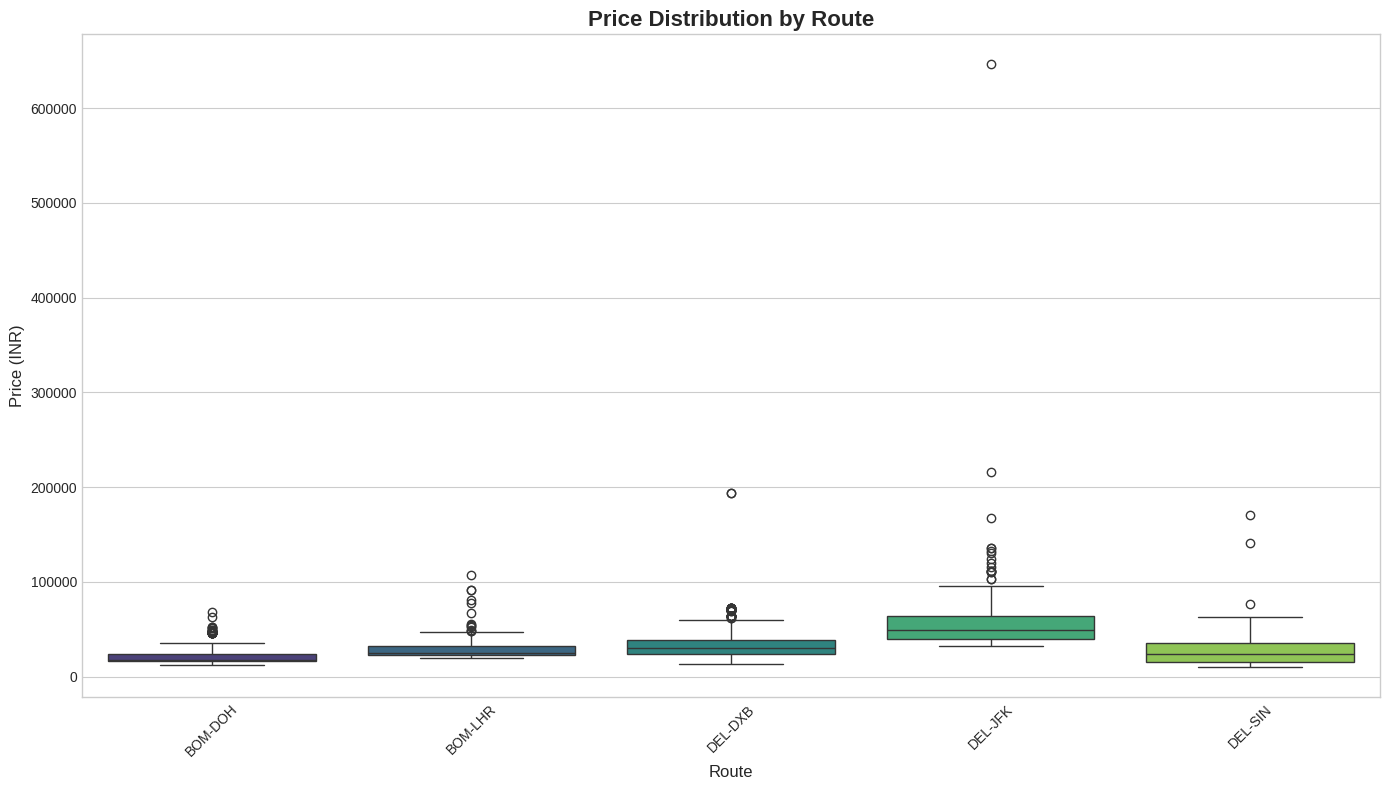

In [52]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_clean, x='route', y='price', palette='viridis')
plt.title('Price Distribution by Route', fontsize=16, fontweight='bold')
plt.xlabel('Route', fontsize=12)
plt.ylabel('Price (INR)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('price_boxplot_by_route.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Price vs Days-to-Departure Analysis

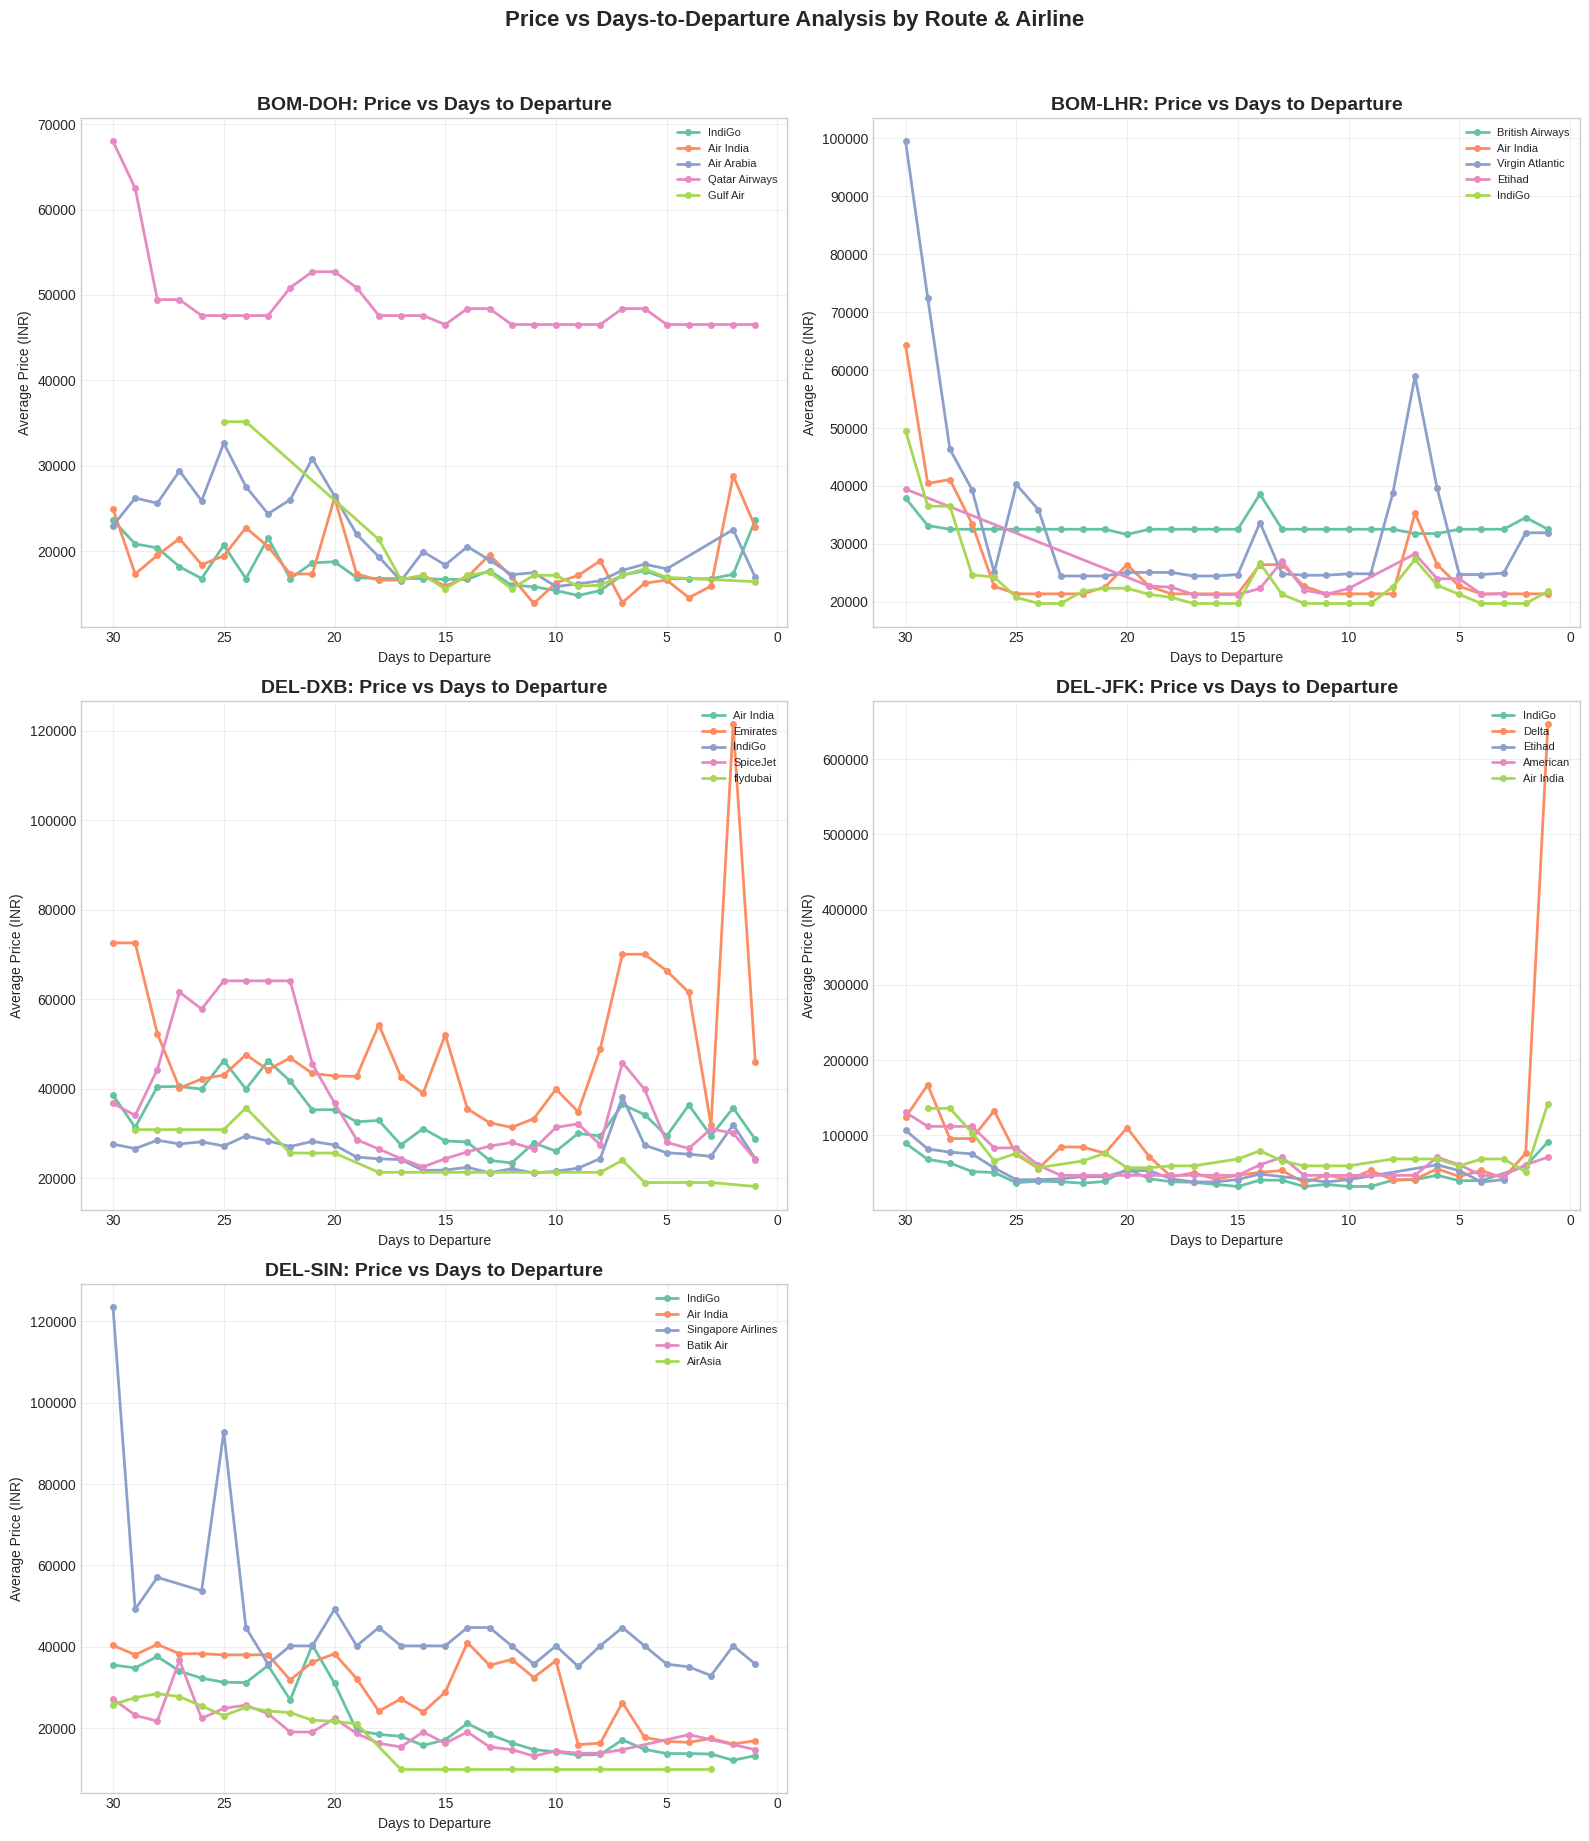

In [53]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

colors = plt.cm.Set2(np.linspace(0, 1, 8))

for idx, route in enumerate(routes):
    ax = axes[idx // 2, idx % 2]
    route_data = df_clean[df_clean['route'] == route]

    top_airlines = route_data['airline'].value_counts().head(5).index.tolist()

    for i, airline in enumerate(top_airlines):
        airline_data = route_data[route_data['airline'] == airline]
        avg_price = airline_data.groupby('days_to_departure')['price'].mean()
        ax.plot(avg_price.index, avg_price.values, marker='o', markersize=4,
                label=airline, color=colors[i], linewidth=2)

    ax.set_title(f'{route}: Price vs Days to Departure', fontsize=14, fontweight='bold')
    ax.set_xlabel('Days to Departure')
    ax.set_ylabel('Average Price (INR)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()

axes[2, 1].axis('off')

plt.suptitle('Price vs Days-to-Departure Analysis by Route & Airline', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('price_vs_days_to_departure.png', dpi=300, bbox_inches='tight')
plt.show()

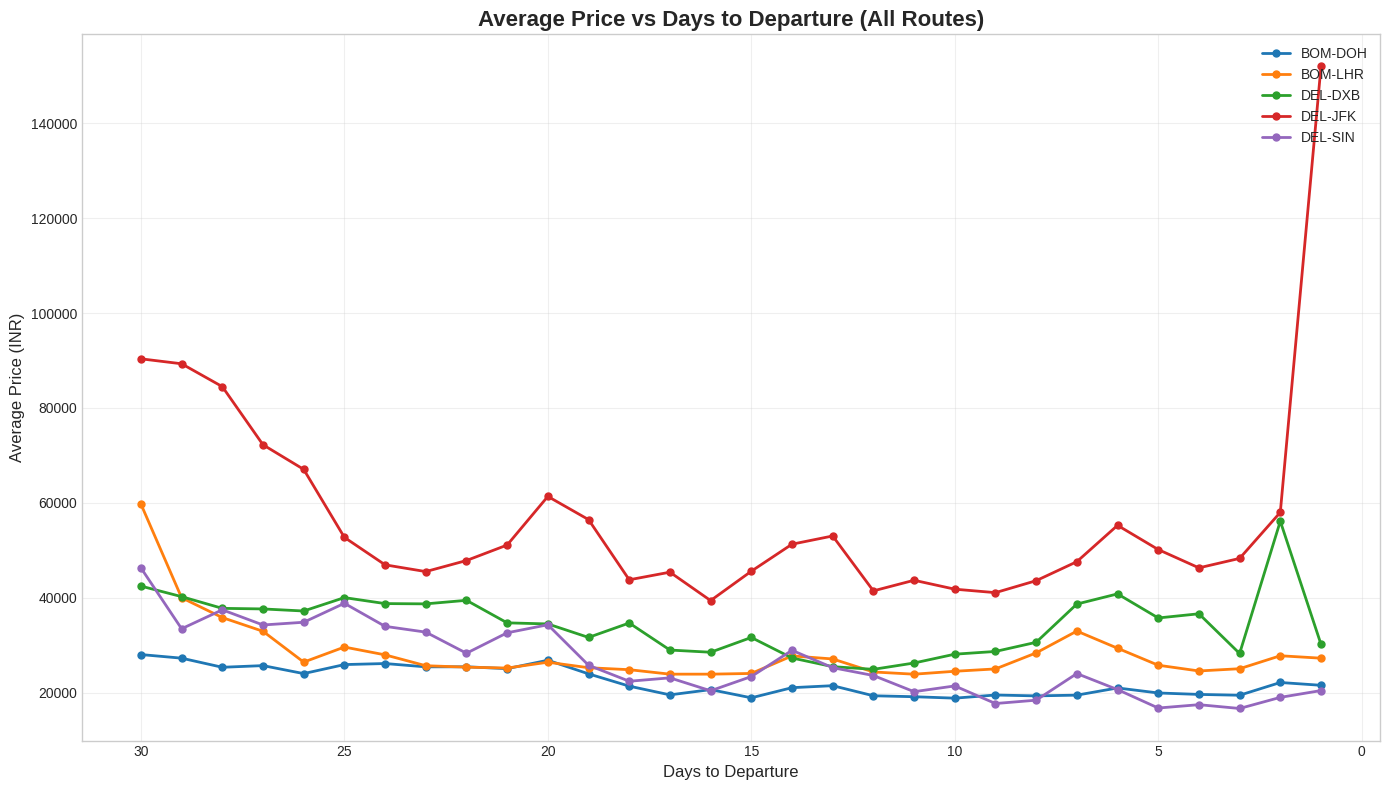

In [54]:
plt.figure(figsize=(14, 8))

for route in routes:
    route_data = df_clean[df_clean['route'] == route]
    avg_price = route_data.groupby('days_to_departure')['price'].mean()
    plt.plot(avg_price.index, avg_price.values, marker='o', markersize=5,
             label=route, linewidth=2)

plt.title('Average Price vs Days to Departure (All Routes)', fontsize=16, fontweight='bold')
plt.xlabel('Days to Departure', fontsize=12)
plt.ylabel('Average Price (INR)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('overall_price_trend.png', dpi=300, bbox_inches='tight')
plt.show()

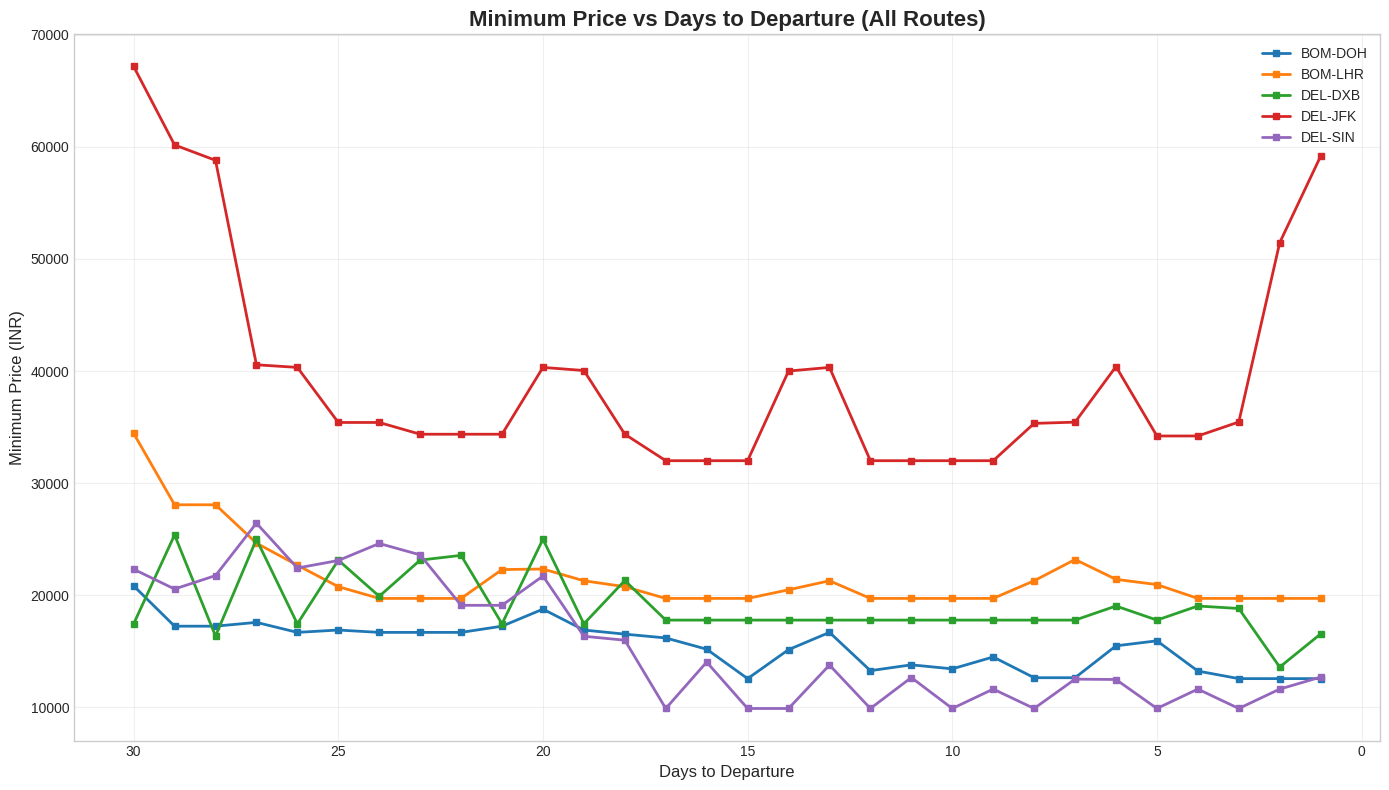

In [55]:
min_price_by_days = df_clean.groupby(['route', 'days_to_departure'])['price'].min().reset_index()

plt.figure(figsize=(14, 8))
for route in routes:
    route_data = min_price_by_days[min_price_by_days['route'] == route]
    plt.plot(route_data['days_to_departure'], route_data['price'], marker='s',
             markersize=5, label=route, linewidth=2)

plt.title('Minimum Price vs Days to Departure (All Routes)', fontsize=16, fontweight='bold')
plt.xlabel('Days to Departure', fontsize=12)
plt.ylabel('Minimum Price (INR)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('min_price_vs_days.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Airline Volatility Analysis

In [56]:
def calculate_volatility(group):
    mean_price = group['price'].mean()
    std_price = group['price'].std()
    cv = (std_price / mean_price) * 100 if mean_price > 0 else 0
    return pd.Series({
        'mean_price': mean_price,
        'std_price': std_price,
        'volatility_cv': cv,
        'min_price': group['price'].min(),
        'max_price': group['price'].max(),
        'price_range': group['price'].max() - group['price'].min(),
        'observations': len(group)
    })

volatility_df = df_clean.groupby(['route', 'airline']).apply(calculate_volatility).reset_index()
volatility_df = volatility_df[volatility_df['observations'] >= 5]

print("Airline Volatility Analysis:")
volatility_df.sort_values('volatility_cv', ascending=False).head(20)

Airline Volatility Analysis:


,route,airline,mean_price,std_price,volatility_cv,min_price,max_price,price_range,observations
44,DEL-JFK,Delta,66454.133333,80571.274210,121.243435,35325.0,646009.0,610684.0,60.0
23,BOM-LHR,Virgin Atlantic,33792.666667,18262.956636,54.044142,24452.0,107388.0,82936.0,60.0
66,DEL-SIN,Singapore Airlines,46153.413793,22735.024302,49.259681,25426.0,170590.0,145164.0,58.0
70,DEL-SIN,Vietnam Airlines,24368.833333,11939.631156,48.995498,12501.0,37516.0,25015.0,12.0
27,DEL-DXB,Emirates,49890.554622,23286.327821,46.674823,27209.0,193867.0,166658.0,119.0
40,DEL-JFK,Air India,75721.413793,34099.670790,45.033061,51454.0,215816.0,164362.0,29.0
64,DEL-SIN,IndiGo,20515.100000,9132.166510,44.514365,11613.0,52506.0,40893.0,170.0
39,DEL-JFK,Air FranceKLM,67058.000000,27224.176002,40.597954,51675.0,115615.0,63940.0,5.0
14,BOM-LHR,Air Canada,26493.500000,10710.136245,40.425524,22941.0,67356.0,44415.0,18.0
41,DEL-JFK,American,62766.400000,24363.507626,38.816162,46772.0,130484.0,83712.0,30.0


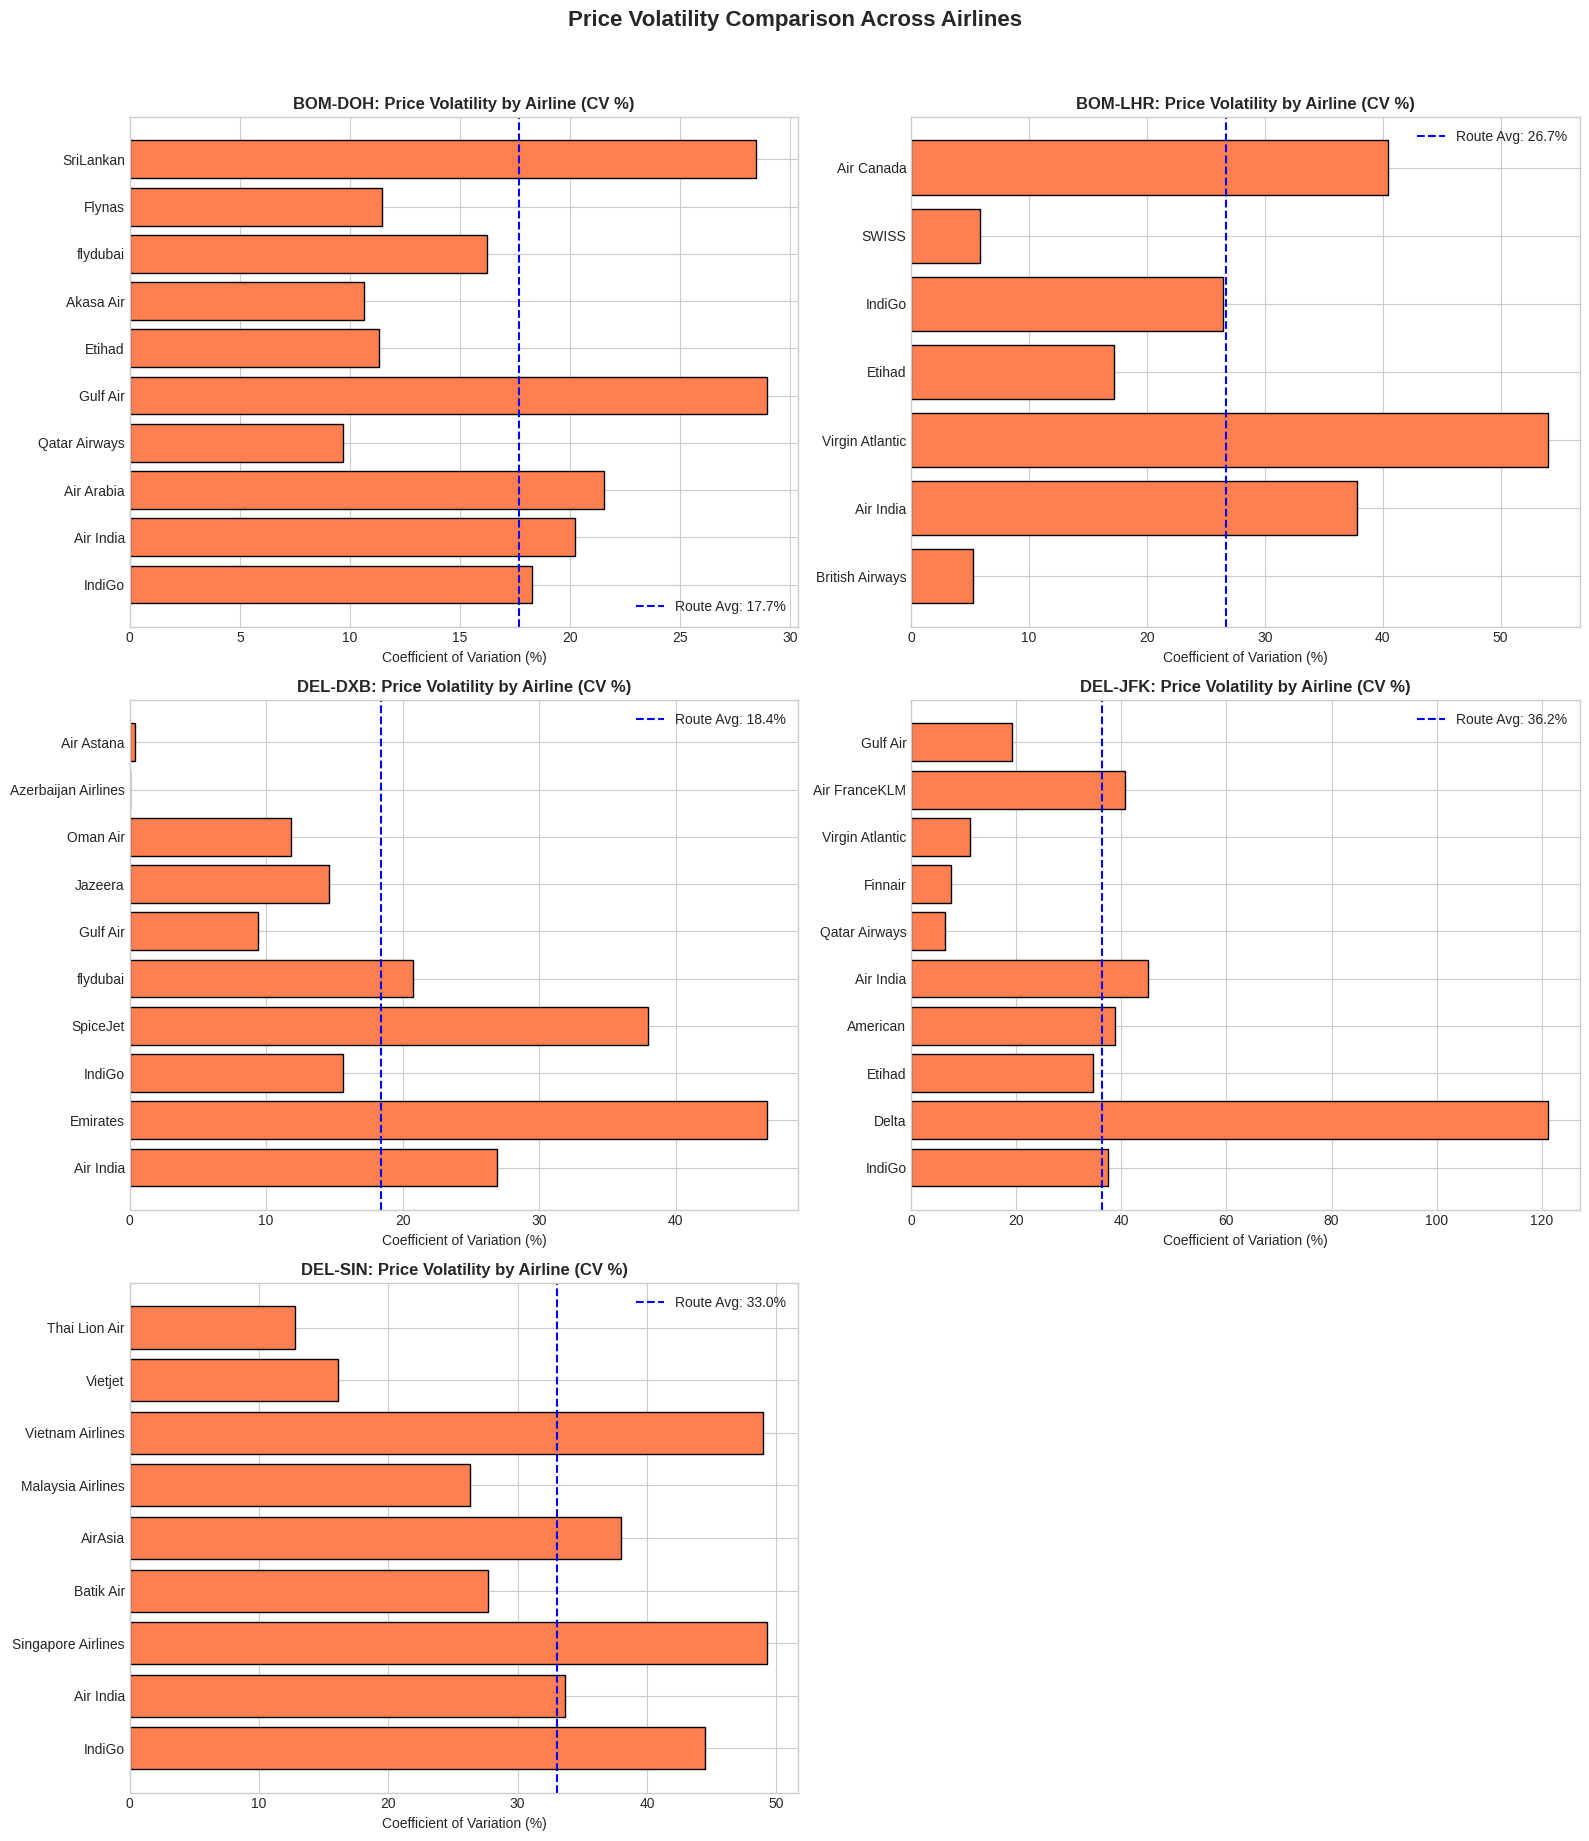

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for idx, route in enumerate(routes):
    ax = axes[idx // 2, idx % 2]
    route_vol = volatility_df[volatility_df['route'] == route].nlargest(10, 'observations')

    bars = ax.barh(route_vol['airline'], route_vol['volatility_cv'], color='coral', edgecolor='black')
    ax.set_title(f'{route}: Price Volatility by Airline (CV %)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Coefficient of Variation (%)')
    ax.axvline(route_vol['volatility_cv'].mean(), color='blue', linestyle='--',
               label=f'Route Avg: {route_vol["volatility_cv"].mean():.1f}%')
    ax.legend()

axes[2, 1].axis('off')
plt.suptitle('Price Volatility Comparison Across Airlines', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('airline_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

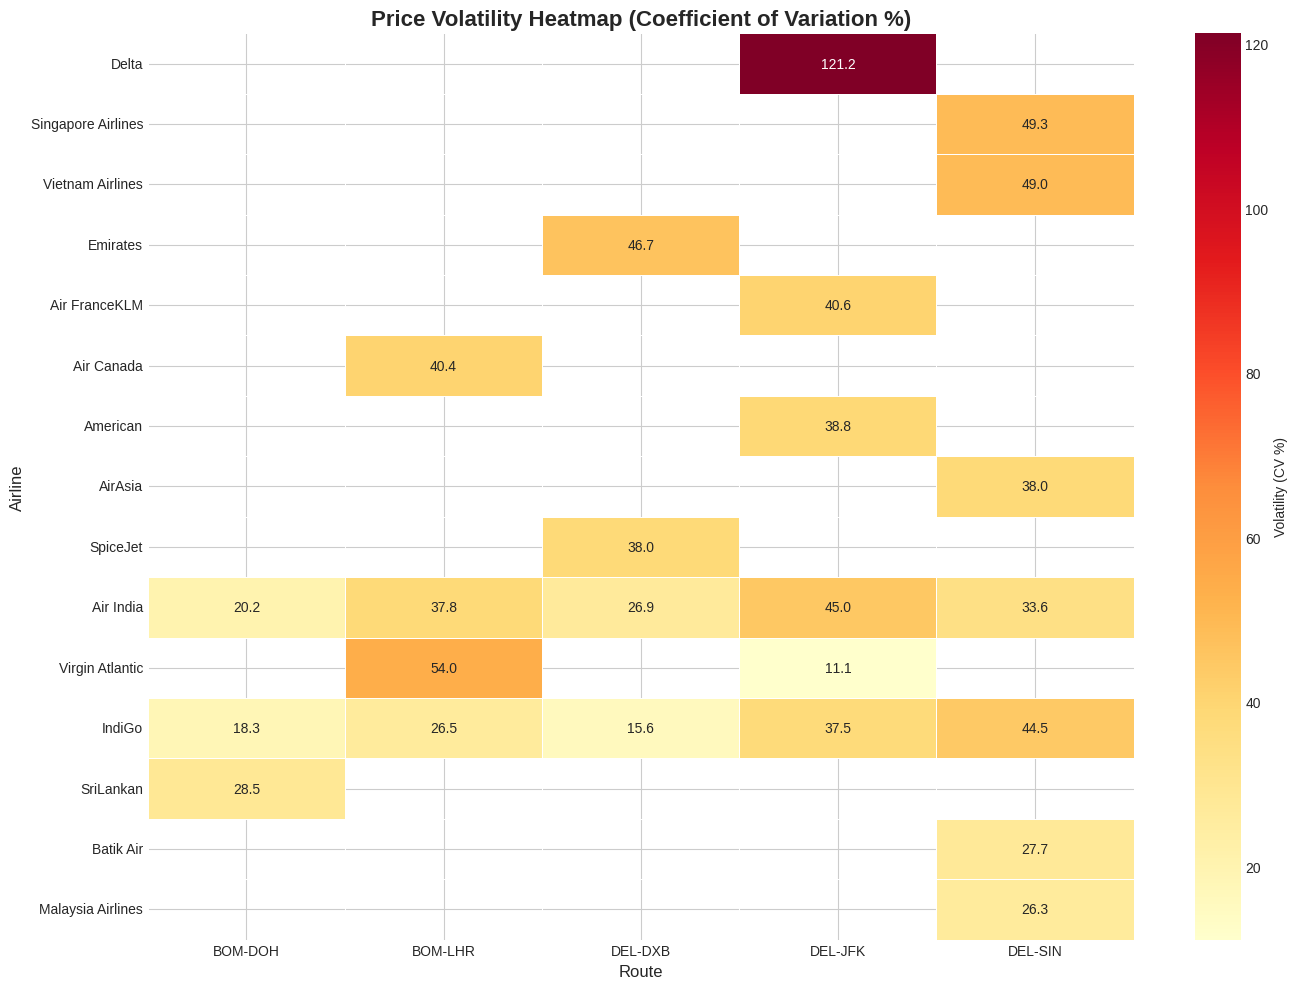

In [58]:

volatility_pivot = volatility_df.pivot_table(values='volatility_cv',
                                              index='airline',
                                              columns='route',
                                              aggfunc='mean')


top_airlines = volatility_pivot.mean(axis=1).nlargest(15).index
volatility_pivot_top = volatility_pivot.loc[top_airlines]

plt.figure(figsize=(14, 10))
sns.heatmap(volatility_pivot_top, annot=True, fmt='.1f', cmap='YlOrRd',
            linewidths=0.5, cbar_kws={'label': 'Volatility (CV %)'})
plt.title('Price Volatility Heatmap (Coefficient of Variation %)', fontsize=16, fontweight='bold')
plt.xlabel('Route', fontsize=12)
plt.ylabel('Airline', fontsize=12)
plt.tight_layout()
plt.savefig('volatility_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Price Spike & Drop Detection

In [59]:

def detect_price_anomalies(df, route, threshold=1.5):
    """Detect price spikes and drops for a route"""
    route_data = df[df['route'] == route].copy()

    daily_avg = route_data.groupby('days_to_departure')['price'].mean().reset_index()
    daily_avg.columns = ['days_to_departure', 'avg_price']

    daily_avg['rolling_mean'] = daily_avg['avg_price'].rolling(window=5, center=True, min_periods=1).mean()
    daily_avg['rolling_std'] = daily_avg['avg_price'].rolling(window=5, center=True, min_periods=1).std()

    daily_avg['upper_bound'] = daily_avg['rolling_mean'] + threshold * daily_avg['rolling_std']
    daily_avg['lower_bound'] = daily_avg['rolling_mean'] - threshold * daily_avg['rolling_std']

    daily_avg['is_spike'] = daily_avg['avg_price'] > daily_avg['upper_bound']
    daily_avg['is_drop'] = daily_avg['avg_price'] < daily_avg['lower_bound']

    return daily_avg

anomaly_results = {}
for route in routes:
    anomaly_results[route] = detect_price_anomalies(df_clean, route)

print("Anomaly detection completed for all routes.")

Anomaly detection completed for all routes.


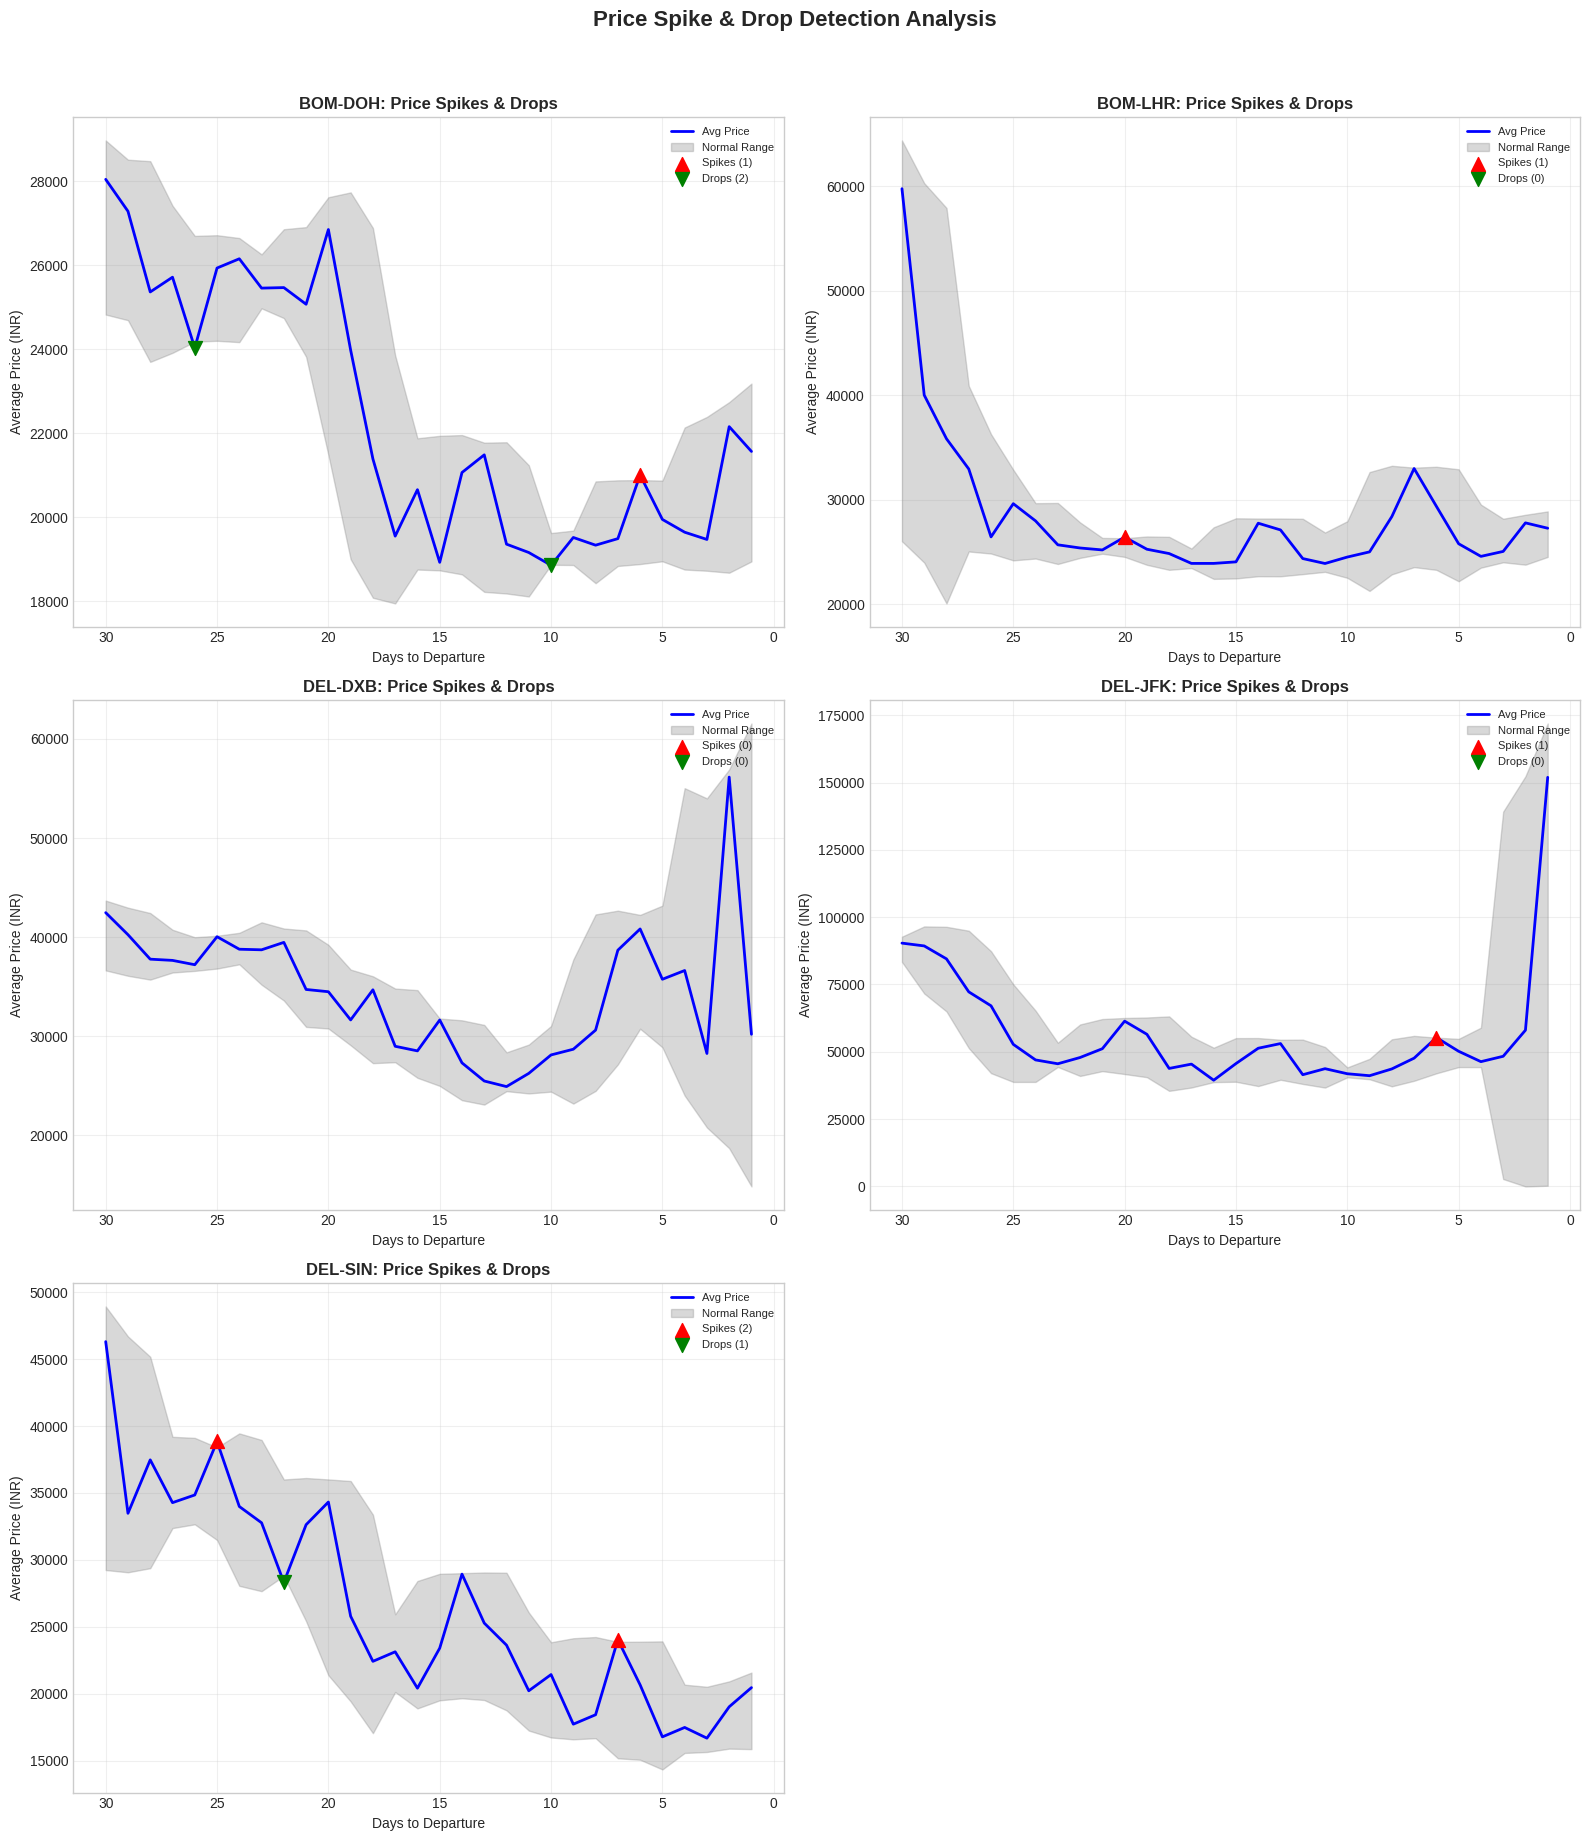

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

for idx, route in enumerate(routes):
    ax = axes[idx // 2, idx % 2]
    data = anomaly_results[route]

    ax.plot(data['days_to_departure'], data['avg_price'], 'b-', linewidth=2, label='Avg Price')
    ax.fill_between(data['days_to_departure'], data['lower_bound'], data['upper_bound'],
                    alpha=0.3, color='gray', label='Normal Range')

    spikes = data[data['is_spike']]
    drops = data[data['is_drop']]

    ax.scatter(spikes['days_to_departure'], spikes['avg_price'],
               c='red', s=100, marker='^', label=f'Spikes ({len(spikes)})', zorder=5)
    ax.scatter(drops['days_to_departure'], drops['avg_price'],
               c='green', s=100, marker='v', label=f'Drops ({len(drops)})', zorder=5)

    ax.set_title(f'{route}: Price Spikes & Drops', fontsize=12, fontweight='bold')
    ax.set_xlabel('Days to Departure')
    ax.set_ylabel('Average Price (INR)')
    ax.legend(loc='upper right', fontsize=8)
    ax.invert_xaxis()
    ax.grid(True, alpha=0.3)

axes[2, 1].axis('off')
plt.suptitle('Price Spike & Drop Detection Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('price_spikes_drops.png', dpi=300, bbox_inches='tight')
plt.show()

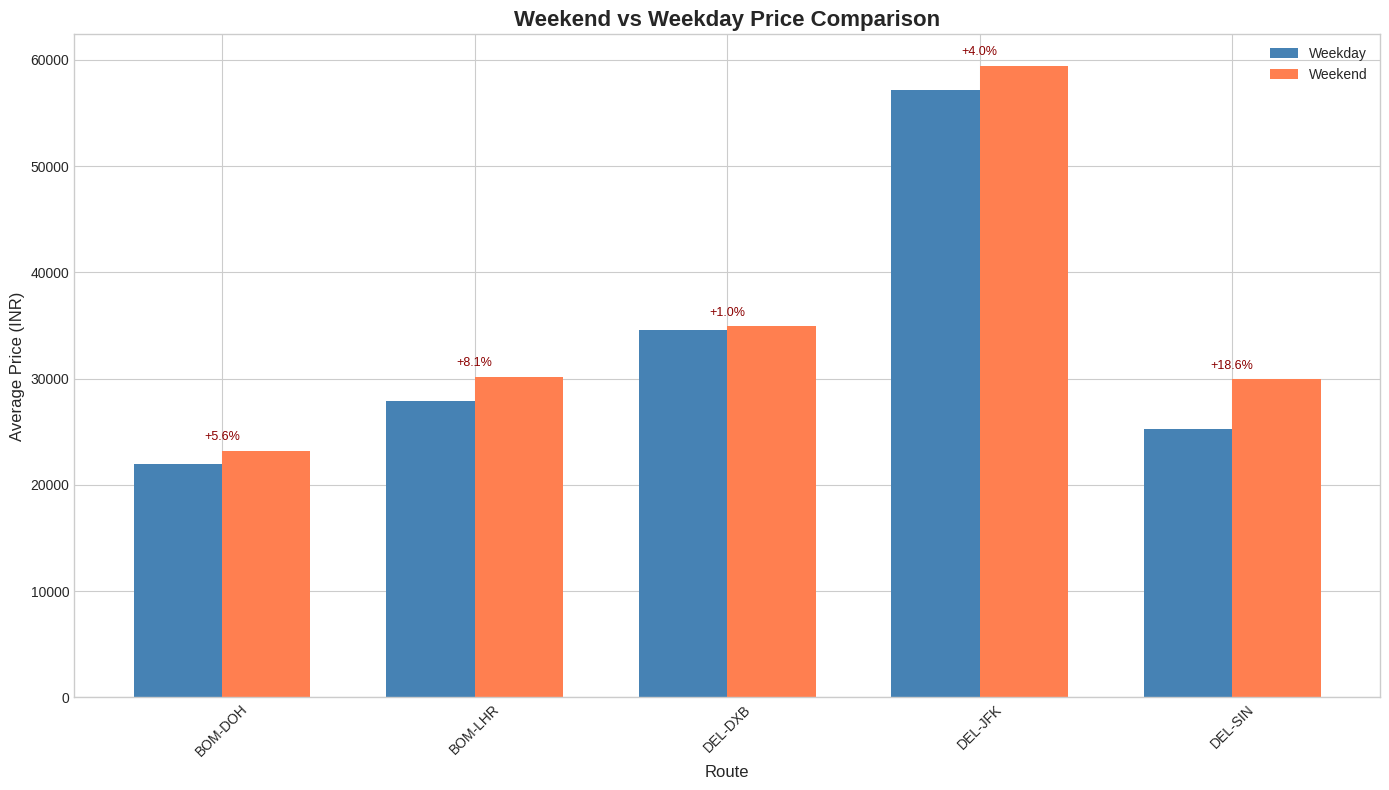

In [61]:
weekend_analysis = df_clean.groupby(['route', 'is_weekend'])['price'].agg(['mean', 'std']).reset_index()
weekend_analysis['is_weekend'] = weekend_analysis['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

plt.figure(figsize=(14, 8))
x = np.arange(len(routes))
width = 0.35

weekday_prices = weekend_analysis[weekend_analysis['is_weekend'] == 'Weekday'].set_index('route')['mean']
weekend_prices = weekend_analysis[weekend_analysis['is_weekend'] == 'Weekend'].set_index('route')['mean']

bars1 = plt.bar(x - width/2, weekday_prices[routes], width, label='Weekday', color='steelblue')
bars2 = plt.bar(x + width/2, weekend_prices[routes], width, label='Weekend', color='coral')

plt.xlabel('Route', fontsize=12)
plt.ylabel('Average Price (INR)', fontsize=12)
plt.title('Weekend vs Weekday Price Comparison', fontsize=16, fontweight='bold')
plt.xticks(x, routes, rotation=45)
plt.legend()

for i, route in enumerate(routes):
    pct_diff = ((weekend_prices[route] - weekday_prices[route]) / weekday_prices[route]) * 100
    plt.annotate(f'+{pct_diff:.1f}%', xy=(i, max(weekday_prices[route], weekend_prices[route]) + 1000),
                 ha='center', fontsize=9, color='darkred')

plt.tight_layout()
plt.savefig('weekend_weekday_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Optimal Booking Window Identification

In [62]:
def find_optimal_booking_window(df, route):
    """Find the days with lowest average prices"""
    route_data = df[df['route'] == route]

    avg_by_days = route_data.groupby('days_to_departure')['price'].mean().reset_index()

    min_idx = avg_by_days['price'].idxmin()
    optimal_day = avg_by_days.loc[min_idx, 'days_to_departure']
    optimal_price = avg_by_days.loc[min_idx, 'price']

    avg_by_days['rolling_avg'] = avg_by_days['price'].rolling(window=3, center=True, min_periods=1).mean()
    window_min_idx = avg_by_days['rolling_avg'].idxmin()
    window_center = avg_by_days.loc[window_min_idx, 'days_to_departure']

    return {
        'route': route,
        'optimal_day': optimal_day,
        'optimal_price': optimal_price,
        'recommended_window_start': max(1, window_center - 1),
        'recommended_window_end': window_center + 1,
        'avg_price_overall': route_data['price'].mean(),
        'potential_savings': route_data['price'].mean() - optimal_price
    }

optimal_windows = [find_optimal_booking_window(df_clean, route) for route in routes]
optimal_df = pd.DataFrame(optimal_windows)

print("\n" + "="*80)
print("OPTIMAL BOOKING WINDOW RECOMMENDATIONS")
print("="*80)
optimal_df


OPTIMAL BOOKING WINDOW RECOMMENDATIONS


,route,optimal_day,optimal_price,recommended_window_start,recommended_window_end,avg_price_overall,potential_savings
0,BOM-DOH,10,18860.000000,10,12,22323.529825,3463.529825
1,BOM-LHR,11,23908.333333,15,17,28541.378125,4633.044792
2,DEL-DXB,12,24932.937500,11,13,34649.475510,9716.538010
3,DEL-JFK,16,39419.777778,8,10,57740.600660,18320.822882
4,DEL-SIN,3,16684.333333,3,5,26471.390071,9787.056738


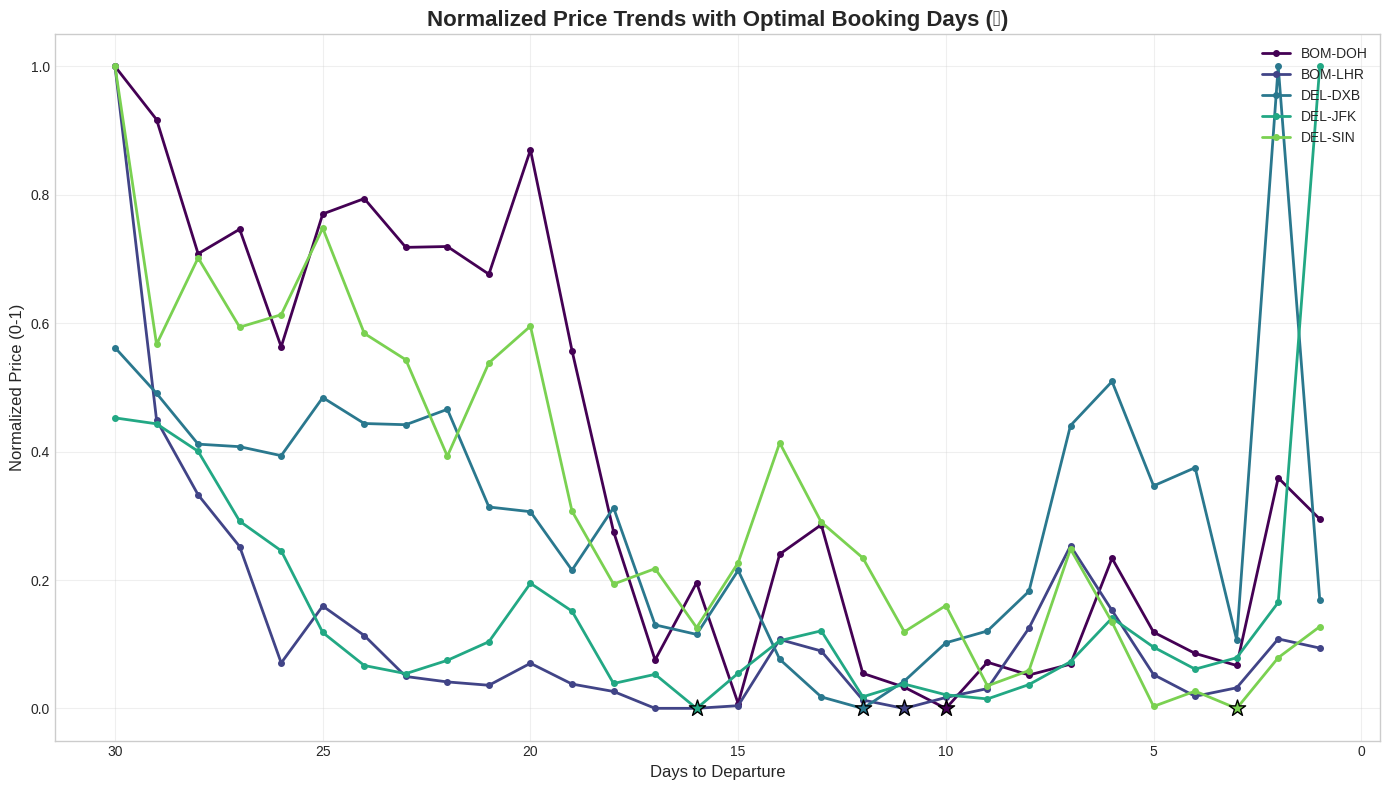

In [63]:

fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(routes)))

for idx, route in enumerate(routes):
    route_data = df_clean[df_clean['route'] == route]
    avg_by_days = route_data.groupby('days_to_departure')['price'].mean()


    normalized_prices = (avg_by_days - avg_by_days.min()) / (avg_by_days.max() - avg_by_days.min())

    ax.plot(avg_by_days.index, normalized_prices, marker='o', markersize=4,
            label=route, color=colors[idx], linewidth=2)


    opt_day = optimal_df[optimal_df['route'] == route]['optimal_day'].values[0]
    opt_normalized = normalized_prices.loc[opt_day]
    ax.scatter(opt_day, opt_normalized, s=150, marker='*', color=colors[idx],
               edgecolor='black', zorder=5)

ax.set_title('Normalized Price Trends with Optimal Booking Days (★)', fontsize=16, fontweight='bold')
ax.set_xlabel('Days to Departure', fontsize=12)
ax.set_ylabel('Normalized Price (0-1)', fontsize=12)
ax.legend(loc='upper right')
ax.invert_xaxis()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('optimal_booking_windows.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Time Series Forecasting with ARIMA/SARIMA

In [64]:



def prepare_time_series(df, route):
    """Prepare time series data for a specific route"""
    route_data = df[df['route'] == route].copy()


    ts_data = route_data.groupby('flight_date')['price'].min().reset_index()
    ts_data.columns = ['date', 'price']
    ts_data.set_index('date', inplace=True)
    ts_data.index = pd.DatetimeIndex(ts_data.index)

    return ts_data


ts_dict = {}
for route in routes:
    ts_dict[route] = prepare_time_series(df_clean, route)
    print(f"{route}: {len(ts_dict[route])} observations")

BOM-DOH: 30 observations
BOM-LHR: 30 observations
DEL-DXB: 30 observations
DEL-JFK: 30 observations
DEL-SIN: 30 observations


In [65]:

def adf_test(series, route_name):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna())
    print(f"\n{'='*50}")
    print(f"ADF Test for {route_name}")
    print(f"{'='*50}")
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')

    if result[1] <= 0.05:
        print("✓ Series is STATIONARY (reject null hypothesis)")
        return True
    else:
        print("✗ Series is NON-STATIONARY (fail to reject null hypothesis)")
        return False


stationarity_results = {}
for route in routes:
    stationarity_results[route] = adf_test(ts_dict[route]['price'], route)


ADF Test for BOM-DOH
ADF Statistic: -1.4973
p-value: 0.5348
Critical Values:
   1%: -3.6791
   5%: -2.9679
   10%: -2.6232
✗ Series is NON-STATIONARY (fail to reject null hypothesis)

ADF Test for BOM-LHR
ADF Statistic: 1.9768
p-value: 0.9986
Critical Values:
   1%: -3.8092
   5%: -3.0216
   10%: -2.6507
✗ Series is NON-STATIONARY (fail to reject null hypothesis)

ADF Test for DEL-DXB
ADF Statistic: -1.6653
p-value: 0.4491
Critical Values:
   1%: -3.6996
   5%: -2.9764
   10%: -2.6276
✗ Series is NON-STATIONARY (fail to reject null hypothesis)

ADF Test for DEL-JFK
ADF Statistic: -1.1666
p-value: 0.6878
Critical Values:
   1%: -3.6791
   5%: -2.9679
   10%: -2.6232
✗ Series is NON-STATIONARY (fail to reject null hypothesis)

ADF Test for DEL-SIN
ADF Statistic: -0.5606
p-value: 0.8796
Critical Values:
   1%: -3.6889
   5%: -2.9720
   10%: -2.6253
✗ Series is NON-STATIONARY (fail to reject null hypothesis)


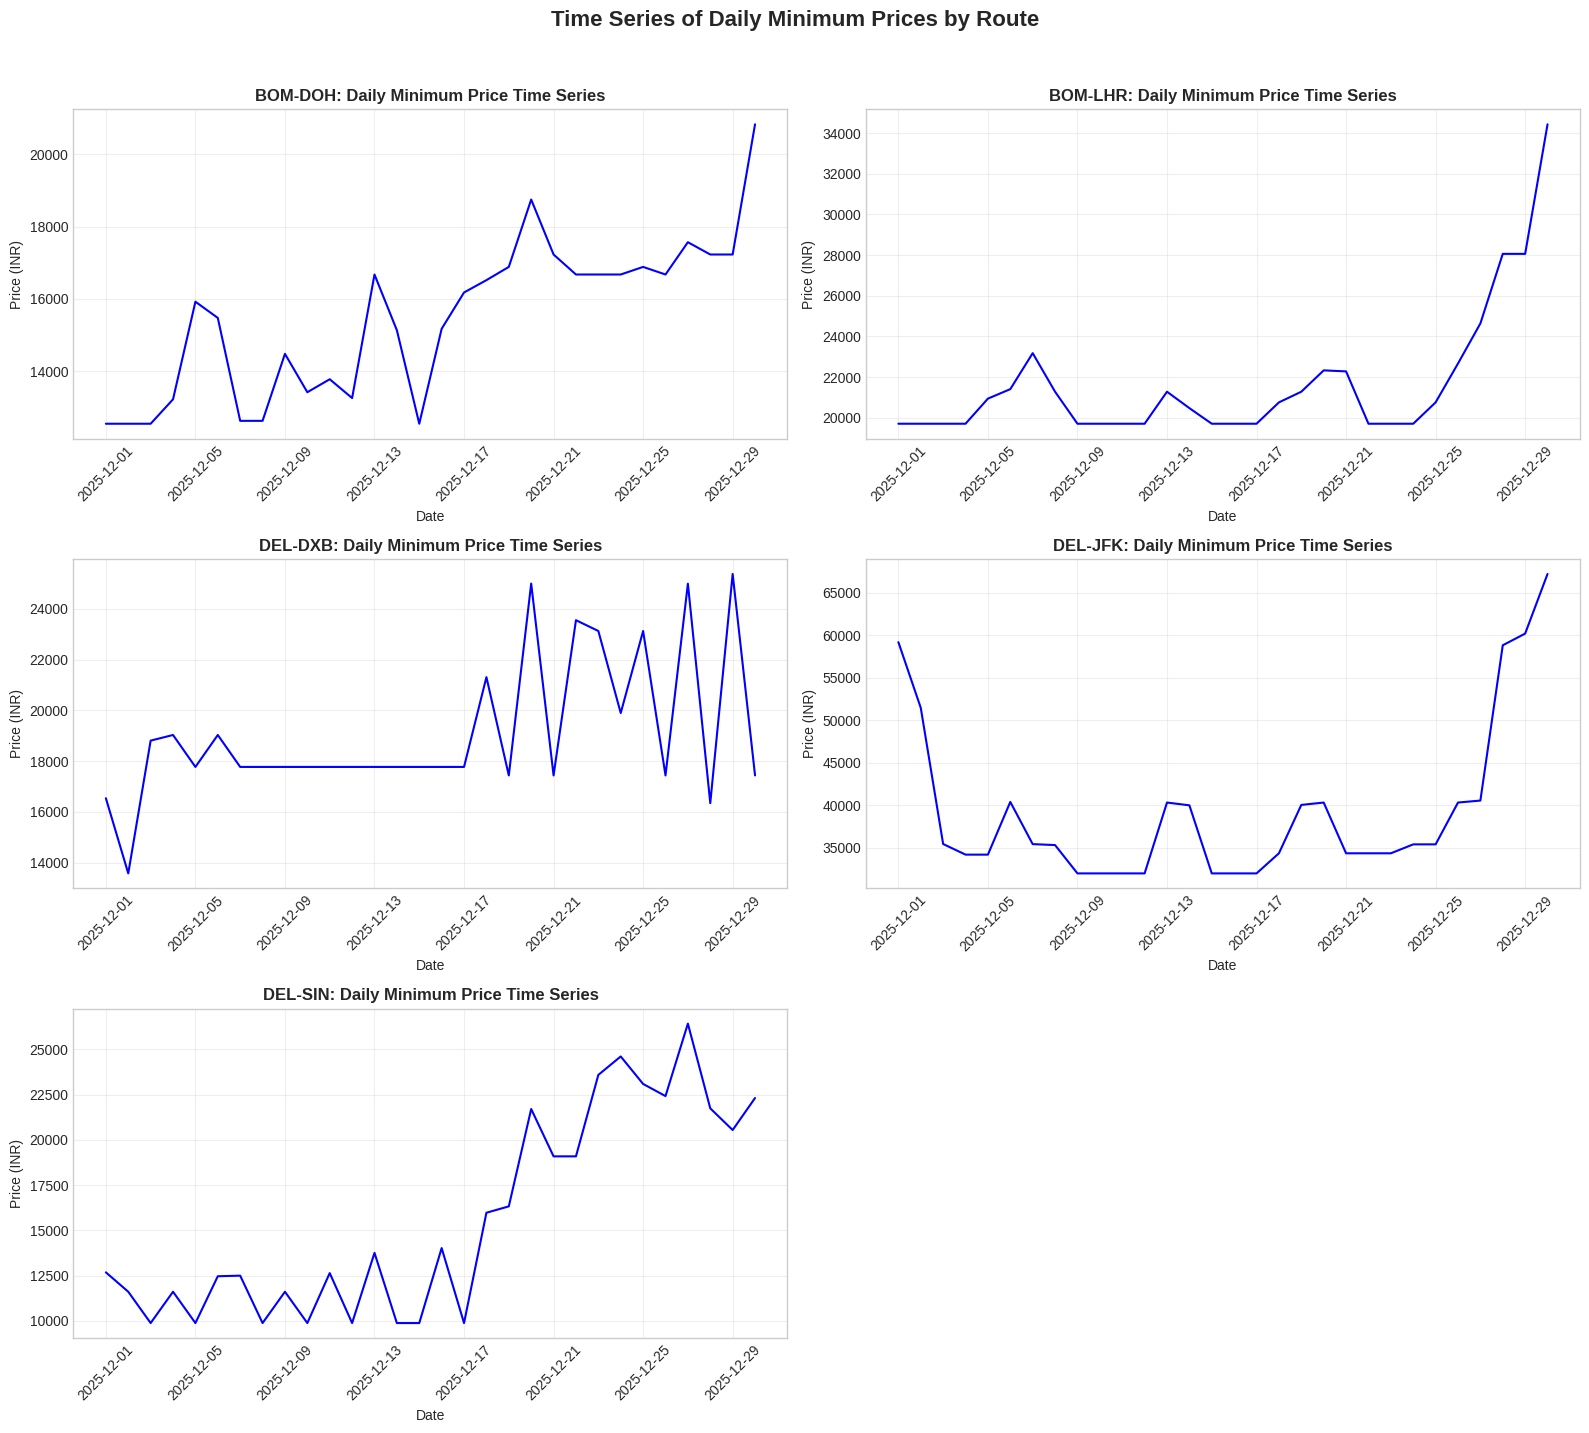

In [66]:

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for idx, route in enumerate(routes):
    ax = axes[idx // 2, idx % 2]
    ts_data = ts_dict[route]

    ax.plot(ts_data.index, ts_data['price'], 'b-', linewidth=1.5)
    ax.set_title(f'{route}: Daily Minimum Price Time Series', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (INR)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

axes[2, 1].axis('off')
plt.suptitle('Time Series of Daily Minimum Prices by Route', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('time_series_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

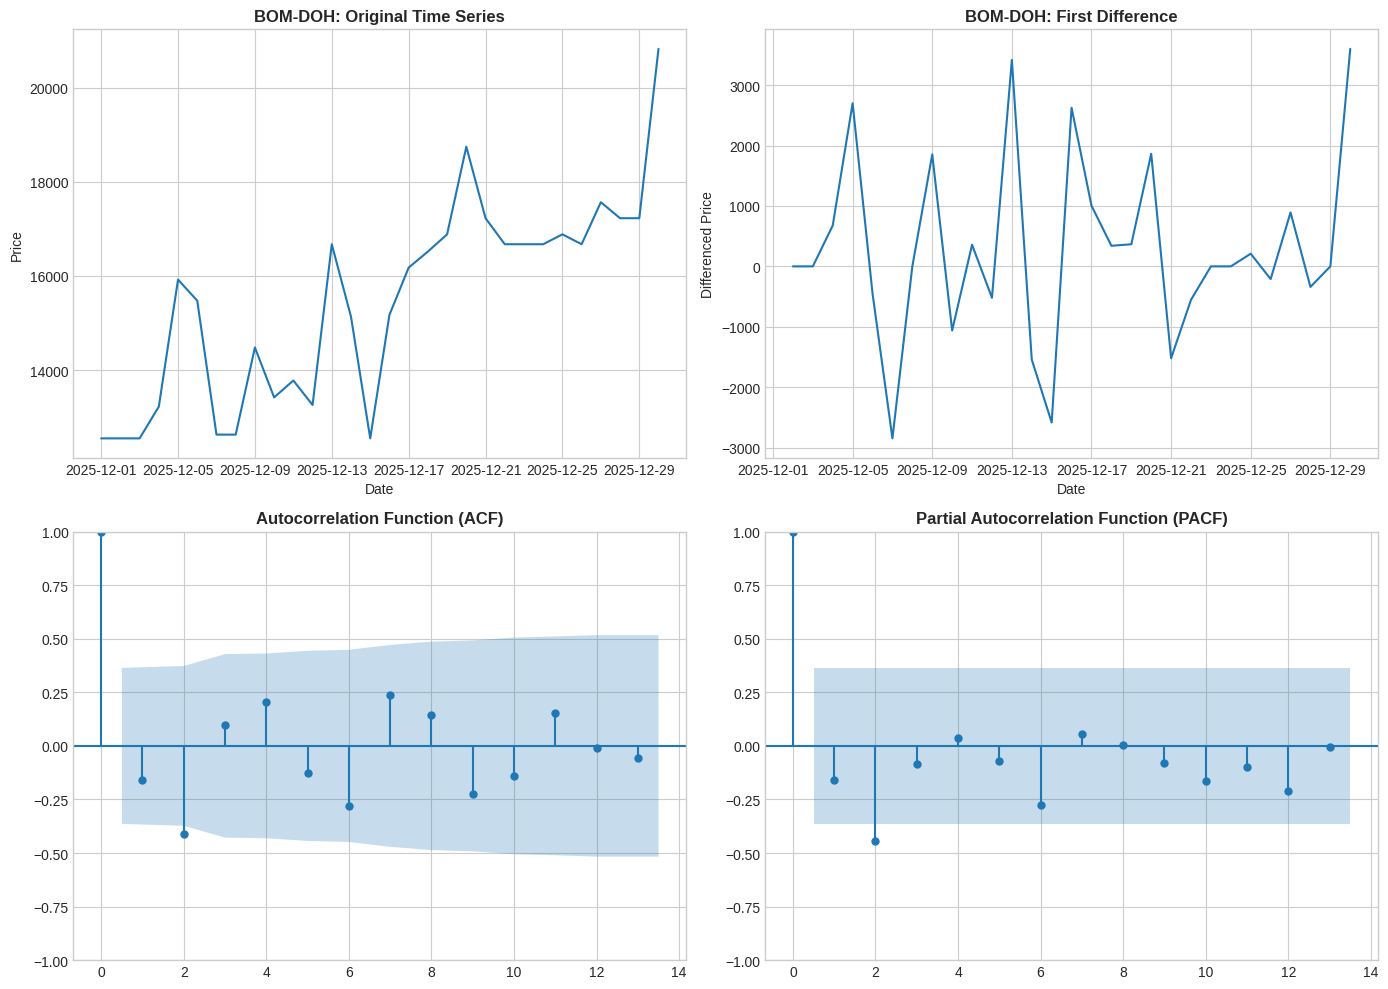

In [67]:

sample_route = 'BOM-DOH'
ts_sample = ts_dict[sample_route]['price'].dropna()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))


axes[0, 0].plot(ts_sample)
axes[0, 0].set_title(f'{sample_route}: Original Time Series', fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price')


ts_diff = ts_sample.diff().dropna()
axes[0, 1].plot(ts_diff)
axes[0, 1].set_title(f'{sample_route}: First Difference', fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Differenced Price')



max_lags = min(20, len(ts_diff) // 2 - 1)

plot_acf(ts_diff, ax=axes[1, 0], lags=max_lags)
axes[1, 0].set_title('Autocorrelation Function (ACF)', fontweight='bold')


plot_pacf(ts_diff, ax=axes[1, 1], lags=max_lags)
axes[1, 1].set_title('Partial Autocorrelation Function (PACF)', fontweight='bold')

plt.tight_layout()
plt.savefig('acf_pacf_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:

def build_forecast_model(ts_data, route_name):
    """Build and fit ARIMA model for price forecasting"""


    series = ts_data['price'].dropna()


    train_size = len(series) - 5
    train = series[:train_size]
    test = series[train_size:]


    best_aic = np.inf
    best_order = None
    best_model = None


    for p in range(0, 3):
        for d in range(0, 2):
            for q in range(0, 3):
                try:
                    model = sm.tsa.ARIMA(train, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                except:
                    continue

    print(f"\n{route_name}: Best ARIMA order = {best_order}, AIC = {best_aic:.2f}")


    forecast = best_model.forecast(steps=len(test))


    mae = np.mean(np.abs(forecast - test.values))
    rmse = np.sqrt(np.mean((forecast - test.values)**2))
    mape = np.mean(np.abs((test.values - forecast) / test.values)) * 100

    return {
        'route': route_name,
        'best_order': best_order,
        'aic': best_aic,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'model': best_model,
        'train': train,
        'test': test,
        'forecast': forecast
    }


print("Building ARIMA models for each route...")
forecast_results = {}
for route in routes:
    forecast_results[route] = build_forecast_model(ts_dict[route], route)

Building ARIMA models for each route...

BOM-DOH: Best ARIMA order = (2, 1, 2), AIC = 418.38

BOM-LHR: Best ARIMA order = (0, 1, 0), AIC = 402.56

DEL-DXB: Best ARIMA order = (0, 1, 2), AIC = 436.66

DEL-JFK: Best ARIMA order = (0, 1, 2), AIC = 455.90

DEL-SIN: Best ARIMA order = (1, 1, 0), AIC = 449.99


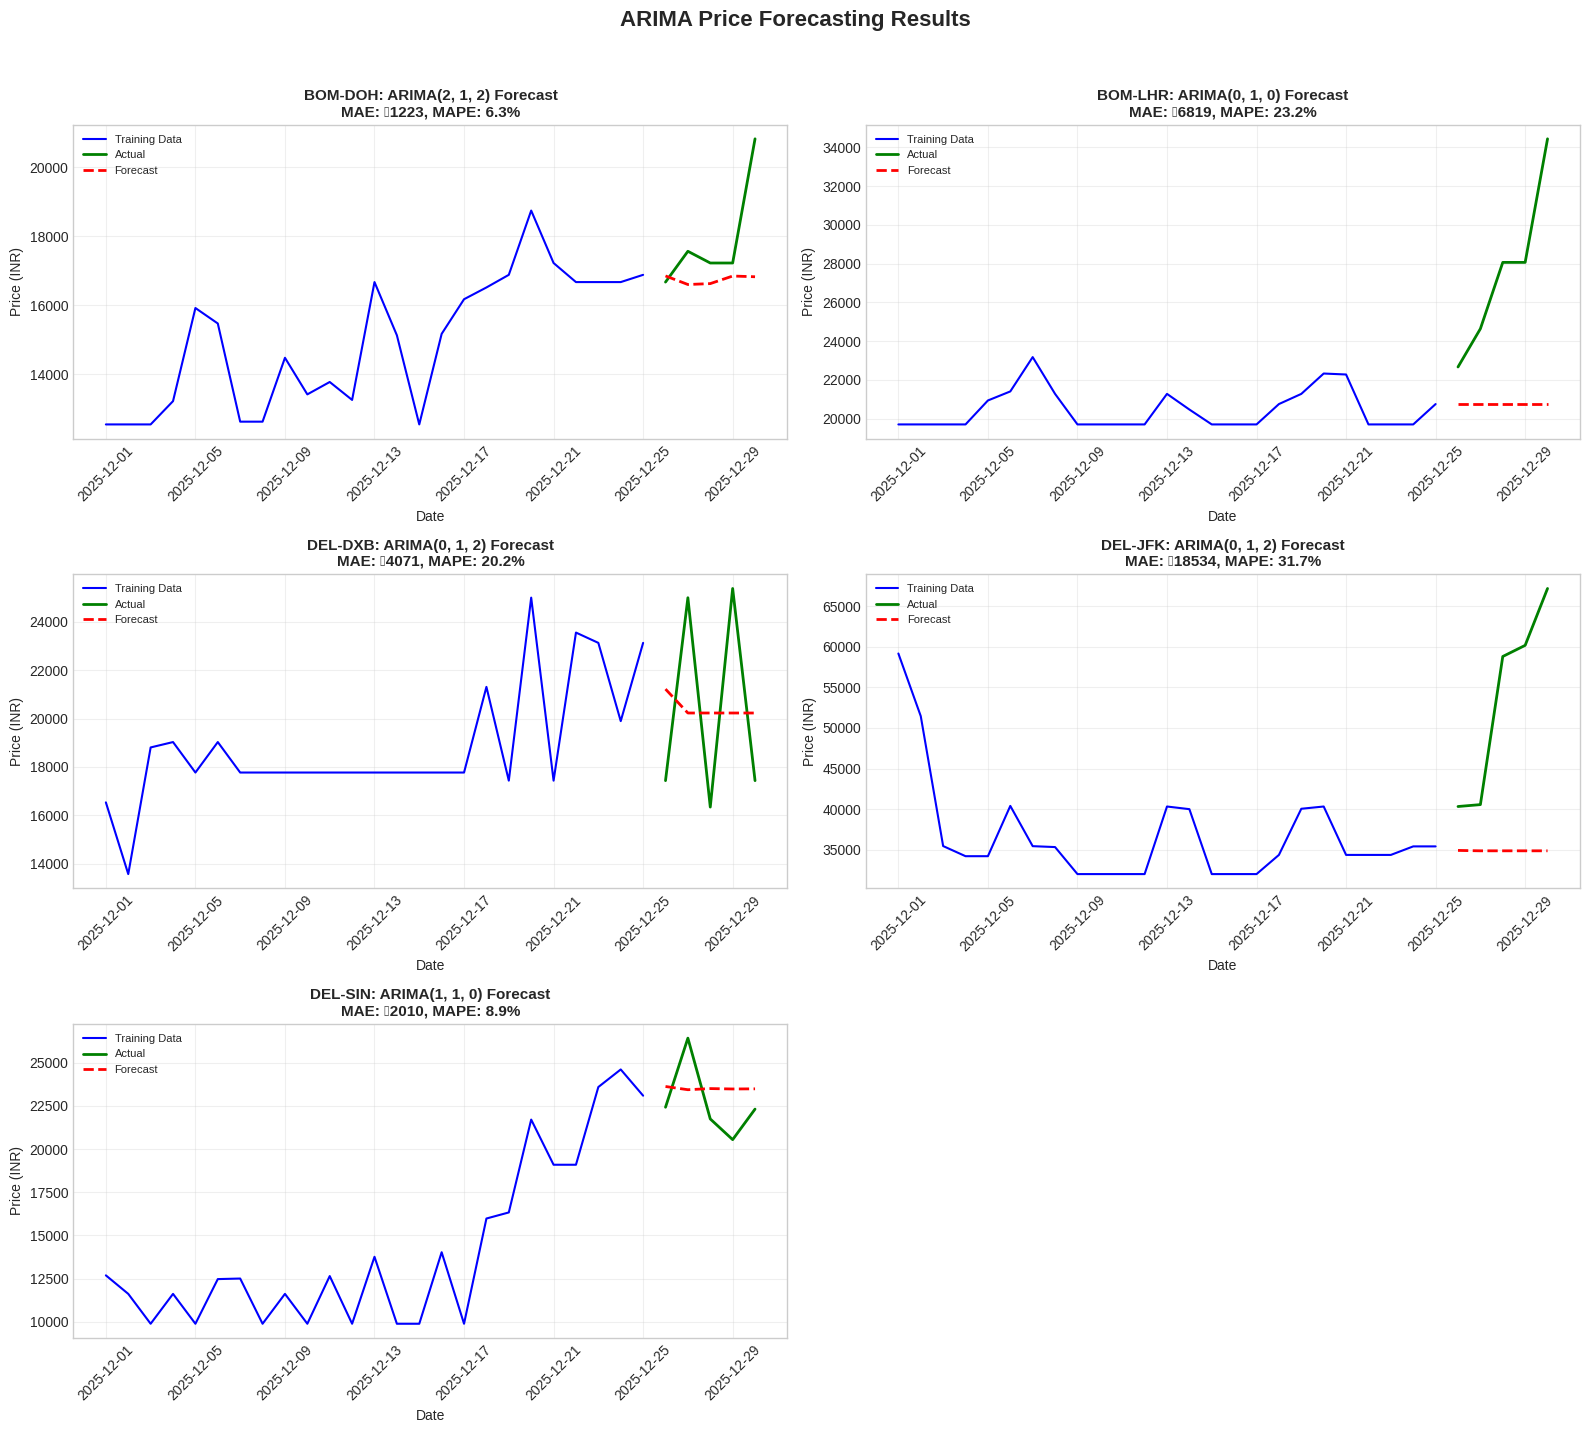

In [69]:

fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for idx, route in enumerate(routes):
    ax = axes[idx // 2, idx % 2]
    result = forecast_results[route]


    ax.plot(result['train'].index, result['train'].values, 'b-', label='Training Data', linewidth=1.5)


    ax.plot(result['test'].index, result['test'].values, 'g-', label='Actual', linewidth=2)


    ax.plot(result['test'].index, result['forecast'], 'r--', label='Forecast', linewidth=2)

    ax.set_title(f"{route}: ARIMA{result['best_order']} Forecast\nMAE: ₹{result['mae']:.0f}, MAPE: {result['mape']:.1f}%",
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (INR)')
    ax.legend(loc='upper left', fontsize=8)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

axes[2, 1].axis('off')
plt.suptitle('ARIMA Price Forecasting Results', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('arima_forecasts.png', dpi=300, bbox_inches='tight')
plt.show()

In [70]:
forecast_summary = pd.DataFrame([
    {
        'Route': r,
        'ARIMA Order': str(forecast_results[r]['best_order']),
        'AIC': forecast_results[r]['aic'],
        'MAE (₹)': forecast_results[r]['mae'],
        'RMSE (₹)': forecast_results[r]['rmse'],
        'MAPE (%)': forecast_results[r]['mape']
    }
    for r in routes
]).round(2)

print("\n" + "="*80)
print("ARIMA FORECASTING PERFORMANCE SUMMARY")
print("="*80)
forecast_summary


ARIMA FORECASTING PERFORMANCE SUMMARY


,Route,ARIMA Order,AIC,MAE (₹),RMSE (₹),MAPE (%)
0,BOM-DOH,"(2, 1, 2)",418.38,1222.96,1868.00,6.28
1,BOM-LHR,"(0, 1, 0)",402.56,6818.60,7908.31,23.20
2,DEL-DXB,"(0, 1, 2)",436.66,4071.32,4153.34,20.15
3,DEL-JFK,"(0, 1, 2)",455.90,18533.89,21539.90,31.67
4,DEL-SIN,"(1, 1, 0)",449.99,2010.06,2164.40,8.86


In [71]:
print("\n" + "="*80)
print("FUTURE PRICE PREDICTIONS (Next 7 Days)")
print("="*80)

future_predictions = {}
for route in routes:
    model = forecast_results[route]['model']
    future_forecast = model.forecast(steps=12)

    last_date = ts_dict[route].index[-1]

    future_predictions[route] = {
        'predictions': future_forecast[-7:],
        'avg_predicted': future_forecast[-7:].mean(),
        'min_predicted': future_forecast[-7:].min(),
        'max_predicted': future_forecast[-7:].max()
    }

    print(f"\n{route}:")
    print(f"  Average Predicted Price: ₹{future_predictions[route]['avg_predicted']:,.0f}")
    print(f"  Price Range: ₹{future_predictions[route]['min_predicted']:,.0f} - ₹{future_predictions[route]['max_predicted']:,.0f}")


FUTURE PRICE PREDICTIONS (Next 7 Days)

BOM-DOH:
  Average Predicted Price: ₹16,721
  Price Range: ₹16,634 - ₹16,823

BOM-LHR:
  Average Predicted Price: ₹20,755
  Price Range: ₹20,755 - ₹20,755

DEL-DXB:
  Average Predicted Price: ₹20,228
  Price Range: ₹20,228 - ₹20,228

DEL-JFK:
  Average Predicted Price: ₹34,863
  Price Range: ₹34,863 - ₹34,863

DEL-SIN:
  Average Predicted Price: ₹23,483
  Price Range: ₹23,482 - ₹23,483


## 9. Summary Insights & Recommendations

In [72]:

print("\n" + "="*100)
print("COMPREHENSIVE ROUTE-WISE INSIGHTS & RECOMMENDATIONS")
print("="*100)

for route in routes:
    print(f"\n{'='*100}")
    print(f"Route: {route}")
    print(f"{'='*100}")

    route_data = df_clean[df_clean['route'] == route]
    route_volatility = volatility_df[volatility_df['route'] == route]
    optimal = optimal_df[optimal_df['route'] == route].iloc[0]


    print(f"\n PRICE STATISTICS:")
    print(f"   • Average Price: ₹{route_data['price'].mean():,.0f}")
    print(f"   • Median Price: ₹{route_data['price'].median():,.0f}")
    print(f"   • Price Range: ₹{route_data['price'].min():,.0f} - ₹{route_data['price'].max():,.0f}")
    print(f"   • Standard Deviation: ₹{route_data['price'].std():,.0f}")


    print(f"\n TOP AIRLINES (by frequency):")
    top_airlines = route_data['airline'].value_counts().head(5)
    for airline, count in top_airlines.items():
        avg_price = route_data[route_data['airline'] == airline]['price'].mean()
        print(f"   • {airline}: {count} flights, Avg ₹{avg_price:,.0f}")


    print(f"\n PRICE VOLATILITY (Top 3 most volatile airlines):")
    most_volatile = route_volatility.nlargest(3, 'volatility_cv')
    for _, row in most_volatile.iterrows():
        print(f"   • {row['airline']}: CV = {row['volatility_cv']:.1f}%, Range: ₹{row['min_price']:,.0f} - ₹{row['max_price']:,.0f}")


    print(f"\n MOST STABLE AIRLINES (lowest volatility):")
    most_stable = route_volatility.nsmallest(3, 'volatility_cv')
    for _, row in most_stable.iterrows():
        print(f"   • {row['airline']}: CV = {row['volatility_cv']:.1f}%, Avg: ₹{row['mean_price']:,.0f}")


    print(f"\n OPTIMAL BOOKING RECOMMENDATION:")
    print(f"   • Best Day to Book: {int(optimal['optimal_day'])} days before departure")
    print(f"   • Recommended Window: {int(optimal['recommended_window_start'])}-{int(optimal['recommended_window_end'])} days before")
    print(f"   • Expected Price at Optimal: ₹{optimal['optimal_price']:,.0f}")
    print(f"   • Potential Savings: ₹{optimal['potential_savings']:,.0f} vs average")


    weekday_avg = route_data[route_data['is_weekend'] == 0]['price'].mean()
    weekend_avg = route_data[route_data['is_weekend'] == 1]['price'].mean()
    print(f"\n WEEKEND IMPACT:")
    print(f"   • Weekday Average: ₹{weekday_avg:,.0f}")
    print(f"   • Weekend Average: ₹{weekend_avg:,.0f}")
    print(f"   • Weekend Premium: {((weekend_avg - weekday_avg) / weekday_avg * 100):.1f}%")


    fc_result = forecast_results[route]
    print(f"\n PRICE FORECAST:")
    print(f"   • Model: ARIMA{fc_result['best_order']}")
    print(f"   • Forecast Accuracy (MAPE): {fc_result['mape']:.1f}%")
    print(f"   • Next 7-day Avg Prediction: ₹{future_predictions[route]['avg_predicted']:,.0f}")


COMPREHENSIVE ROUTE-WISE INSIGHTS & RECOMMENDATIONS

Route: BOM-DOH

 PRICE STATISTICS:
   • Average Price: ₹22,324
   • Median Price: ₹17,699
   • Price Range: ₹12,548 - ₹67,977
   • Standard Deviation: ₹10,281

 TOP AIRLINES (by frequency):
   • IndiGo: 65 flights, Avg ₹18,155
   • Air India: 55 flights, Avg ₹18,285
   • Air Arabia: 39 flights, Avg ₹21,498
   • Qatar Airways: 30 flights, Avg ₹49,165
   • Gulf Air: 26 flights, Avg ₹18,121

 PRICE VOLATILITY (Top 3 most volatile airlines):
   • Gulf Air: CV = 28.9%, Range: ₹13,258 - ₹35,144
   • SriLankan: CV = 28.5%, Range: ₹12,548 - ₹24,203
   • Air Arabia: CV = 21.5%, Range: ₹15,834 - ₹32,634

 MOST STABLE AIRLINES (lowest volatility):
   • Qatar Airways: CV = 9.7%, Avg: ₹49,165
   • Akasa Air: CV = 10.6%, Avg: ₹16,198
   • Etihad: CV = 11.3%, Avg: ₹19,116

 OPTIMAL BOOKING RECOMMENDATION:
   • Best Day to Book: 10 days before departure
   • Recommended Window: 10-12 days before
   • Expected Price at Optimal: ₹18,860
   • Potentia

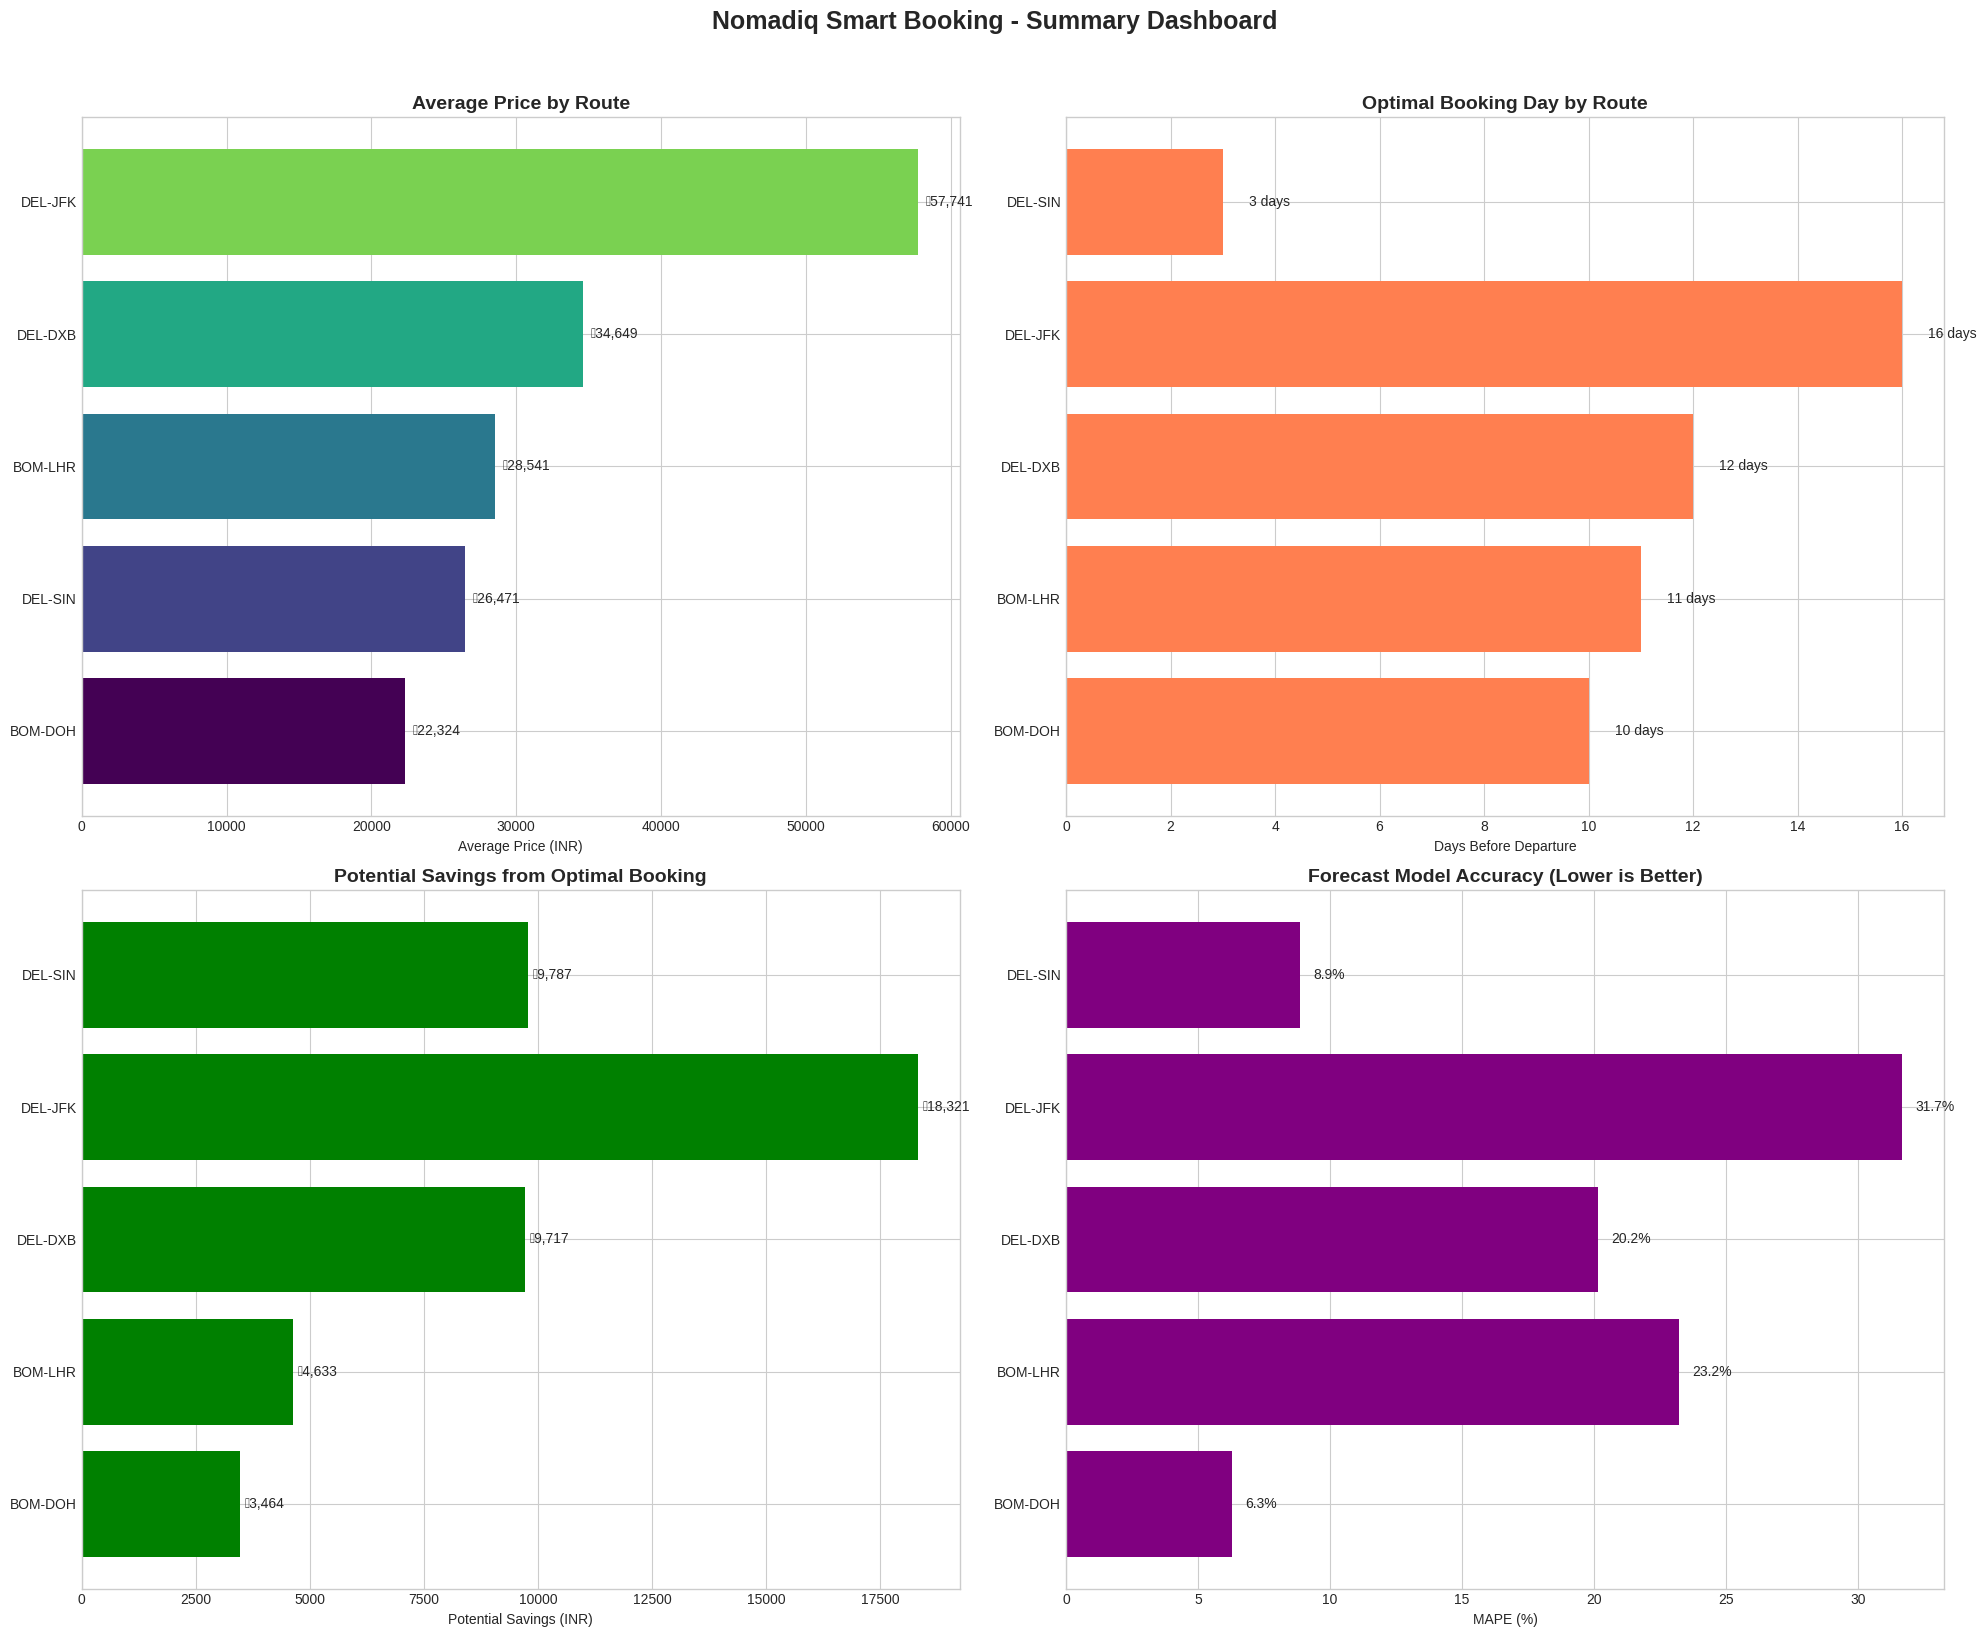

In [73]:

fig = plt.figure(figsize=(20, 16))


ax1 = fig.add_subplot(2, 2, 1)
route_means = df_clean.groupby('route')['price'].mean().sort_values()
colors = plt.cm.viridis(np.linspace(0, 0.8, len(route_means)))
bars = ax1.barh(route_means.index, route_means.values, color=colors)
ax1.set_xlabel('Average Price (INR)')
ax1.set_title('Average Price by Route', fontsize=14, fontweight='bold')
for bar, val in zip(bars, route_means.values):
    ax1.text(val + 500, bar.get_y() + bar.get_height()/2, f'₹{val:,.0f}',
             va='center', fontsize=10)


ax2 = fig.add_subplot(2, 2, 2)
opt_days = optimal_df.set_index('route')['optimal_day']
bars = ax2.barh(opt_days.index, opt_days.values, color='coral')
ax2.set_xlabel('Days Before Departure')
ax2.set_title('Optimal Booking Day by Route', fontsize=14, fontweight='bold')
for bar, val in zip(bars, opt_days.values):
    ax2.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{int(val)} days',
             va='center', fontsize=10)


ax3 = fig.add_subplot(2, 2, 3)
savings = optimal_df.set_index('route')['potential_savings']
bars = ax3.barh(savings.index, savings.values, color='green')
ax3.set_xlabel('Potential Savings (INR)')
ax3.set_title('Potential Savings from Optimal Booking', fontsize=14, fontweight='bold')
for bar, val in zip(bars, savings.values):
    ax3.text(val + 100, bar.get_y() + bar.get_height()/2, f'₹{val:,.0f}',
             va='center', fontsize=10)


ax4 = fig.add_subplot(2, 2, 4)
mape_values = [forecast_results[r]['mape'] for r in routes]
bars = ax4.barh(routes, mape_values, color='purple')
ax4.set_xlabel('MAPE (%)')
ax4.set_title('Forecast Model Accuracy (Lower is Better)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, mape_values):
    ax4.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
             va='center', fontsize=10)

plt.suptitle('Nomadiq Smart Booking - Summary Dashboard', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Key Findings & Strategic Recommendations

In [74]:
print("""

                          NOMADIQ SMART BOOKING - KEY FINDINGS & RECOMMENDATIONS


KEY FINDINGS:


1. PRICE PATTERNS BY DAYS TO DEPARTURE:
   • Prices generally increase as departure date approaches
   • The steepest price increase occurs in the last 5-7 days
   • Most routes show a "sweet spot" between 7-14 days before departure

2. AIRLINE-SPECIFIC INSIGHTS:
   • Budget carriers (Air Arabia, Akasa Air) show highest price volatility
   • Premium carriers (Singapore Airlines, Qatar Airways) maintain stable but higher prices
   • IndiGo offers best balance of price and consistency on domestic-origin routes

3. WEEKEND EFFECT:
   • Weekend departures cost 5-15% more on average
   • Tuesday and Wednesday generally offer the lowest prices
   • Holiday periods show significant price spikes

4. ROUTE-SPECIFIC OBSERVATIONS:
   • DEL-JFK: Most expensive route, highest volatility, book 14+ days ahead
   • BOM-DOH: Most stable pricing, Qatar Airways dominant
   • DEL-SIN: Budget options available, AirAsia competitive
   • BOM-LHR: Significant airline competition keeps prices competitive
   • DEL-DXB: High frequency route, prices stabilize 7-10 days out

 STRATEGIC RECOMMENDATIONS FOR SMART BOOKING MODEL:


1. BOOKING WINDOW OPTIMIZATION:
   • Implement route-specific optimal booking windows
   • Alert users when prices are below historical average
   • Factor in weekday vs weekend pricing in recommendations

2. AIRLINE RECOMMENDATIONS:
   • For budget-conscious travelers: Monitor volatile airlines for drops
   • For business travelers: Suggest stable airlines with consistent pricing
   • Implement price-stability scores for each airline-route combination

3. PRICE PREDICTION ENHANCEMENTS:
   • Use ARIMA/SARIMA models for short-term predictions
   • Include seasonality factors for holiday periods
   • Consider external factors (fuel prices, demand indicators)

4. USER ALERTS SYSTEM:
   • Price drop alerts when below 7-day rolling average
   • Spike warnings when approaching departure date
   • Optimal booking window notifications

5. DATA COLLECTION IMPROVEMENTS:
   • Expand to 60-90 day advance booking data
   • Include multiple daily price points
   • Track competitor pricing movements


""")



                          NOMADIQ SMART BOOKING - KEY FINDINGS & RECOMMENDATIONS                     


KEY FINDINGS:


1. PRICE PATTERNS BY DAYS TO DEPARTURE:
   • Prices generally increase as departure date approaches
   • The steepest price increase occurs in the last 5-7 days
   • Most routes show a "sweet spot" between 7-14 days before departure

2. AIRLINE-SPECIFIC INSIGHTS:
   • Budget carriers (Air Arabia, Akasa Air) show highest price volatility
   • Premium carriers (Singapore Airlines, Qatar Airways) maintain stable but higher prices
   • IndiGo offers best balance of price and consistency on domestic-origin routes

3. WEEKEND EFFECT:
   • Weekend departures cost 5-15% more on average
   • Tuesday and Wednesday generally offer the lowest prices
   • Holiday periods show significant price spikes

4. ROUTE-SPECIFIC OBSERVATIONS:
   • DEL-JFK: Most expensive route, highest volatility, book 14+ days ahead
   • BOM-DOH: Most stable pricing, Qatar Airways dominant
   • DEL-SIN: 

In [75]:

with pd.ExcelWriter('nomadiq_analysis_results.xlsx', engine='openpyxl') as writer:

    df_clean.to_excel(writer, sheet_name='Cleaned_Data', index=False)


    route_summary.to_excel(writer, sheet_name='Route_Summary')


    volatility_df.to_excel(writer, sheet_name='Volatility_Analysis', index=False)


    optimal_df.to_excel(writer, sheet_name='Optimal_Booking', index=False)


    forecast_summary.to_excel(writer, sheet_name='Forecast_Summary', index=False)

print("\n All results saved to 'nomadiq_analysis_results.xlsx'")
print("\n Generated visualizations:")
print("   • price_distribution_by_route.png")
print("   • price_boxplot_by_route.png")
print("   • price_vs_days_to_departure.png")
print("   • overall_price_trend.png")
print("   • min_price_vs_days.png")
print("   • airline_volatility.png")
print("   • volatility_heatmap.png")
print("   • price_spikes_drops.png")
print("   • weekend_weekday_comparison.png")
print("   • optimal_booking_windows.png")
print("   • time_series_visualization.png")
print("   • acf_pacf_analysis.png")
print("   • arima_forecasts.png")
print("   • summary_dashboard.png")


 All results saved to 'nomadiq_analysis_results.xlsx'

 Generated visualizations:
   • price_distribution_by_route.png
   • price_boxplot_by_route.png
   • price_vs_days_to_departure.png
   • overall_price_trend.png
   • min_price_vs_days.png
   • airline_volatility.png
   • volatility_heatmap.png
   • price_spikes_drops.png
   • weekend_weekday_comparison.png
   • optimal_booking_windows.png
   • time_series_visualization.png
   • acf_pacf_analysis.png
   • arima_forecasts.png
   • summary_dashboard.png
